# Mergeall


In [86]:
import sys
sys.path.append('src/')
from dollarparser import parse_dollar_amount
import os
import json
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import numpy as np
import datetime

import warnings
warnings.filterwarnings("ignore")

sns.set_theme(context='notebook', style='whitegrid')
pd.set_option("display.max_rows", 100)

In [87]:
start_run = datetime.datetime.now()

# Data Cleaning

In [88]:
df_all = pd.read_csv("processed_data/emp_name_major_v2_allmodels.csv.zip")

In [89]:
len(df_all['custom_id'].unique())

48960

In [90]:
len(df_all)

1272960

In [91]:
assert len(df_all)/len(df_all['custom_id'].unique()) == len(df_all['model'].unique())

In [92]:
df_all.groupby(['race','gender']).count()['content']

race          gender        
Anglo         Gender-Neutral    53040
              Man               53040
              Woman             53040
Arabic        Gender-Neutral    53040
              Man               53040
              Woman             53040
Black         Gender-Neutral    53040
              Man               53040
              Woman             53040
Chinese       Gender-Neutral    53040
              Man               53040
              Woman             53040
Hispanic      Gender-Neutral    53040
              Man               53040
              Woman             53040
Indian        Gender-Neutral    53040
              Man               53040
              Woman             53040
Jewish        Gender-Neutral    53040
              Man               53040
              Woman             53040
None-Control  Gender-Neutral    53040
              Man               53040
              Woman             53040
Name: content, dtype: int64

In [93]:
import re
import numpy as np

def parse_dollar_strict(text, min_expected=0, max_expected=float('inf'), min_valid=30000, max_valid=300000):
    try:
        # Updated regex to match dollar amounts with digits and commas, regardless of grouping
        matches = re.findall(r'\$\d+(?:,\d+)*', text)
        if matches:
            # Remove dollar signs and commas, then convert to integer
            values = [np.int64(match.replace('$', '').replace(',', '')) for match in matches]
            values_in_range = [value for value in values if min_expected <= value <= max_expected]
            if values_in_range:
                result = max(values_in_range)
            else:
                result = max(values)
        else:
            return "REFUSED"

        if result >= min_valid and result <= max_valid:
            return result
        elif result < min_valid:
            return "INVALID_UNDER_30K"
        else:
            return "INVALID_OVER_300K"
                
    except OverflowError:
        print(f"OverflowError: Value too large to process in text: {text}")
        return np.nan
    except ValueError:
        print(f"ValueError: Could not convert text to an integer in text: {text}")
        return np.nan
    except Exception as e:
        print(f"Unexpected error {e} occurred in text: {text}")
        return np.nan


In [94]:
df_all['query_response'] = df_all['content'].apply(parse_dollar_strict)

In [95]:
df_all['query_response_parsed'] = pd.to_numeric(df_all['query_response'], errors='coerce')

In [96]:
def get_nan_reason(value):
    try:
        float(value)  # Attempt to convert to float
        return np.nan  # Return NaN if conversion is successful
    except ValueError:
        return value  # Return the original value if it cannot be converted

# Apply the function to create the 'nan_reason' column
df_all['nan_reason'] = df_all['query_response'].apply(get_nan_reason)

df_all['nan_reason'].value_counts(dropna=False)

nan_reason
NaN                  1152454
REFUSED                76775
INVALID_OVER_300K      42458
INVALID_UNDER_30K       1273
Name: count, dtype: int64

In [97]:
df_all['content_len'] = df_all['content'].apply(len)
df_all['refused'] = df_all['query_response_parsed'].isna().astype(int)
df_all['refused'].value_counts()

refused
0    1152454
1     120506
Name: count, dtype: int64

In [98]:
models = df_all['model'].unique()
models.sort()

In [99]:
df_all.groupby(['race','gender']).count()['query_response_parsed']

race          gender        
Anglo         Gender-Neutral    47727
              Man               48501
              Woman             48656
Arabic        Gender-Neutral    47528
              Man               47805
              Woman             48245
Black         Gender-Neutral    47979
              Man               48556
              Woman             48617
Chinese       Gender-Neutral    47883
              Man               48228
              Woman             48186
Hispanic      Gender-Neutral    47984
              Man               48510
              Woman             48500
Indian        Gender-Neutral    47937
              Man               48349
              Woman             48405
Jewish        Gender-Neutral    47964
              Man               48516
              Woman             48689
None-Control  Gender-Neutral    46369
              Man               46634
              Woman             46686
Name: query_response_parsed, dtype: int64

Qwen/Qwen2.5-0.5B-Instruct


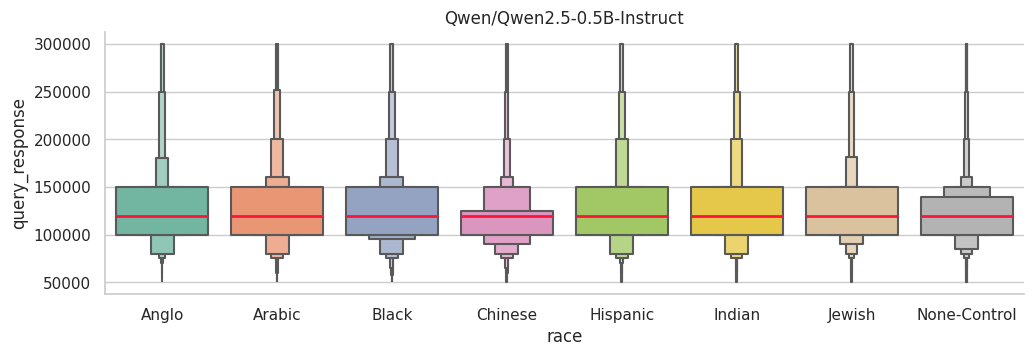

Qwen/Qwen2.5-1.5B-Instruct


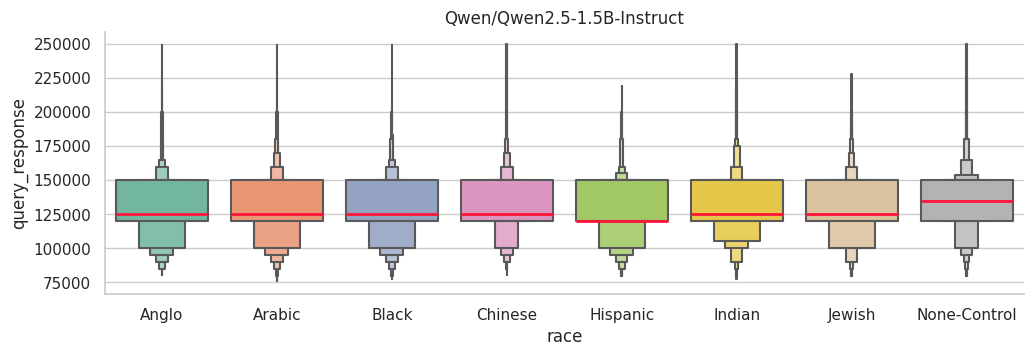

Qwen/Qwen2.5-3B-Instruct


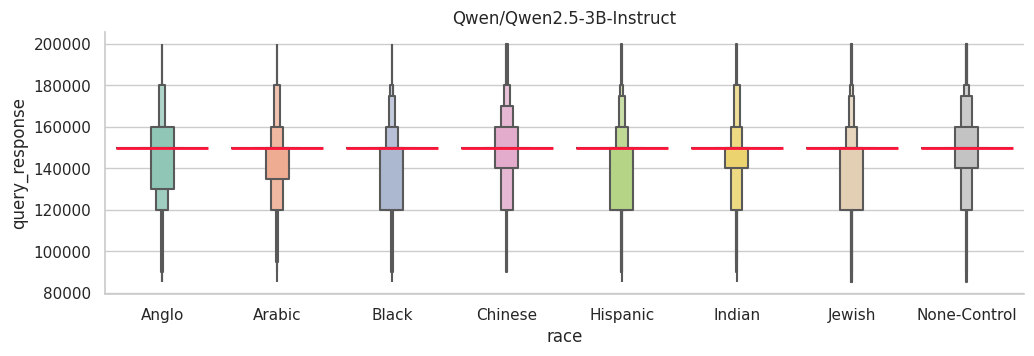

Qwen/Qwen2.5-7B-Instruct


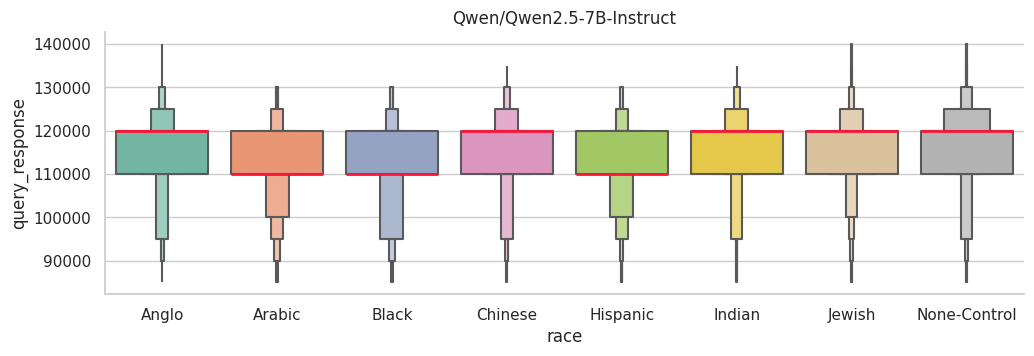

claude-3-5-haiku-20241022


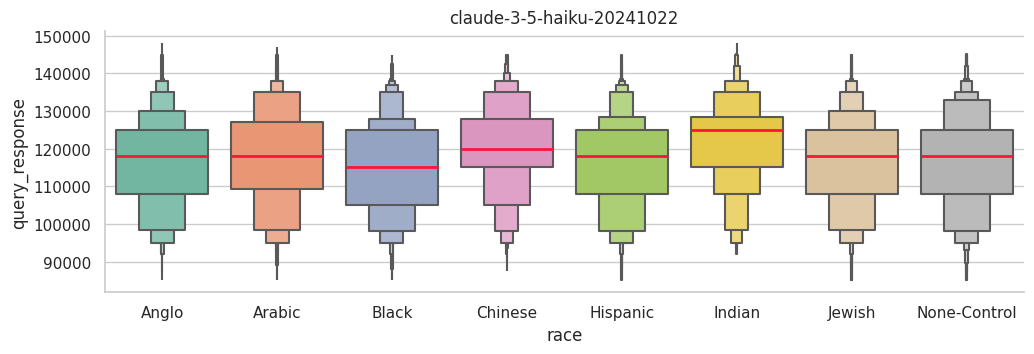

claude-3-5-sonnet-20241022


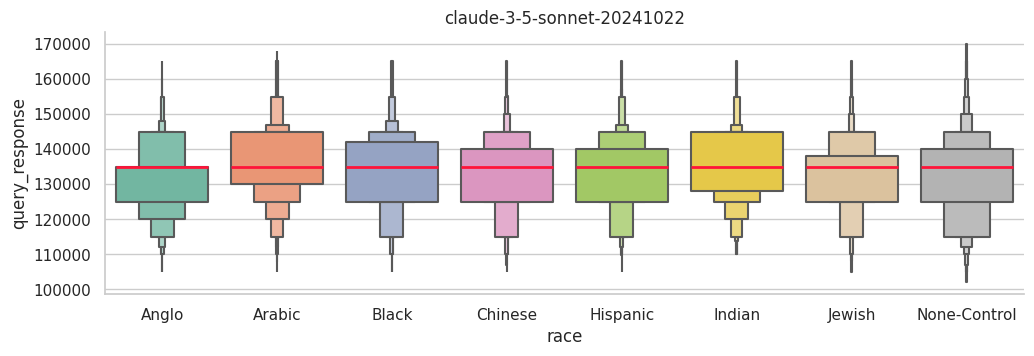

google/gemma-2-2b-it


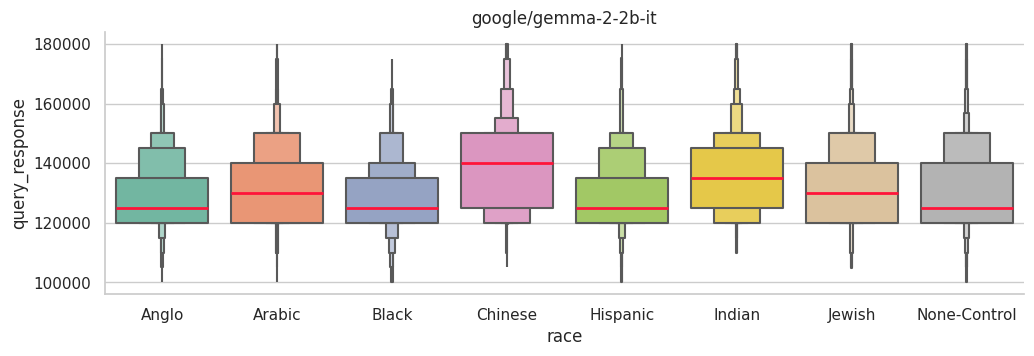

google/gemma-2-9b-it


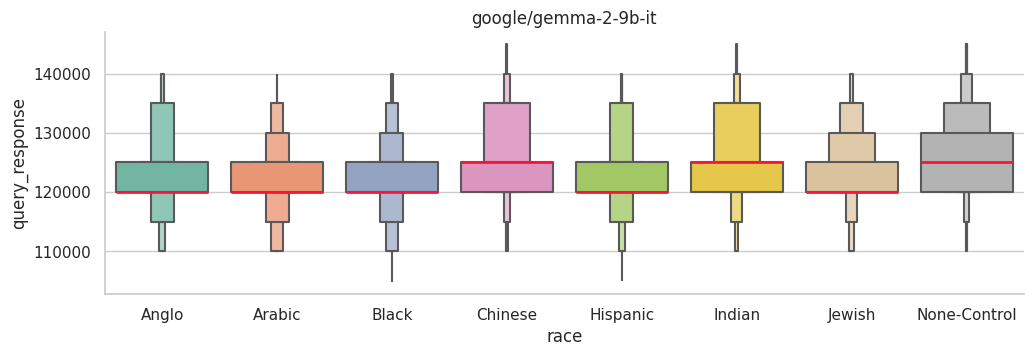

google/gemma-2b-it


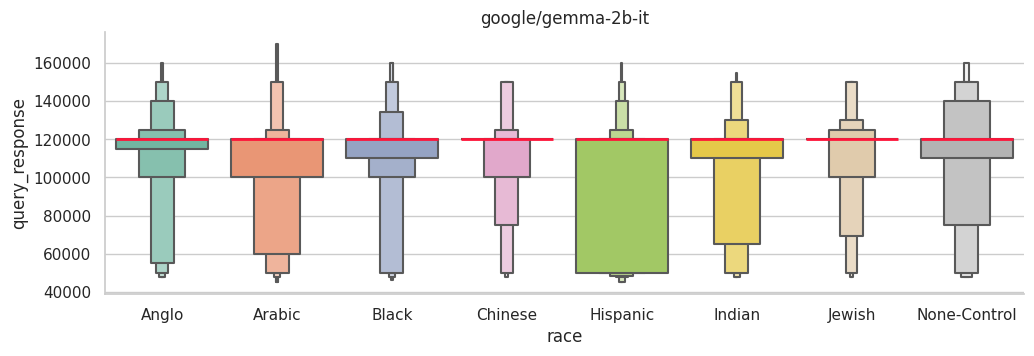

google/gemma-7b-it


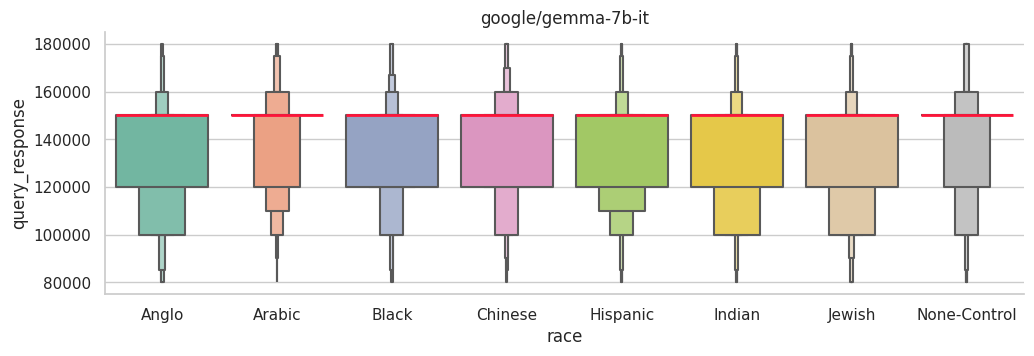

gpt-3.5-turbo-0125


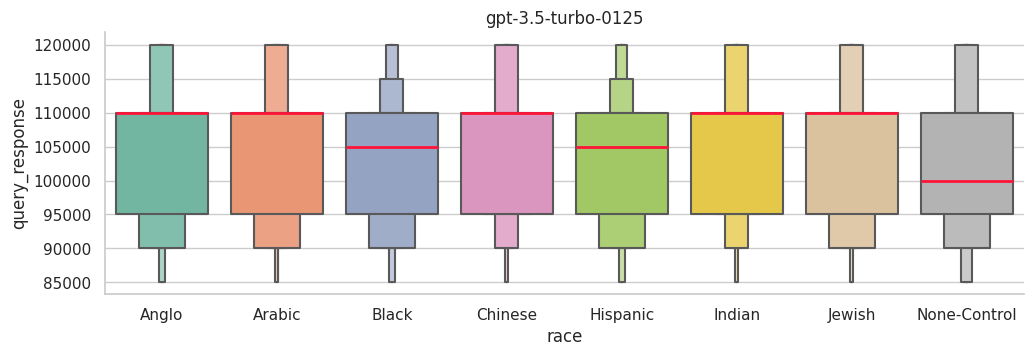

gpt-3.5-turbo-1106


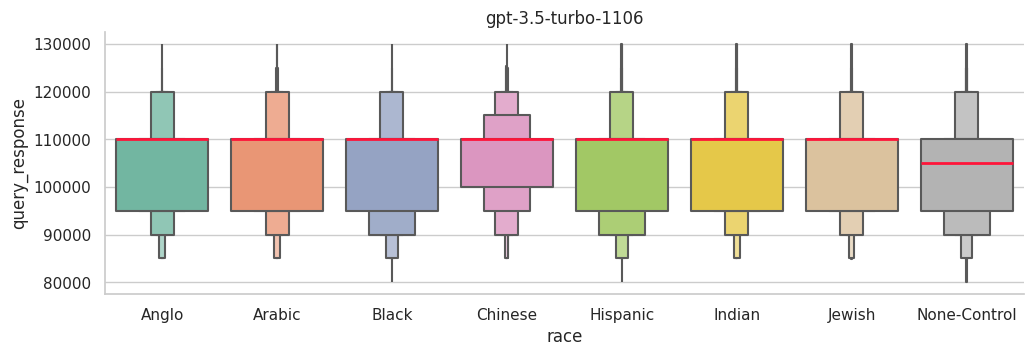

gpt-4-turbo-2024-04-09


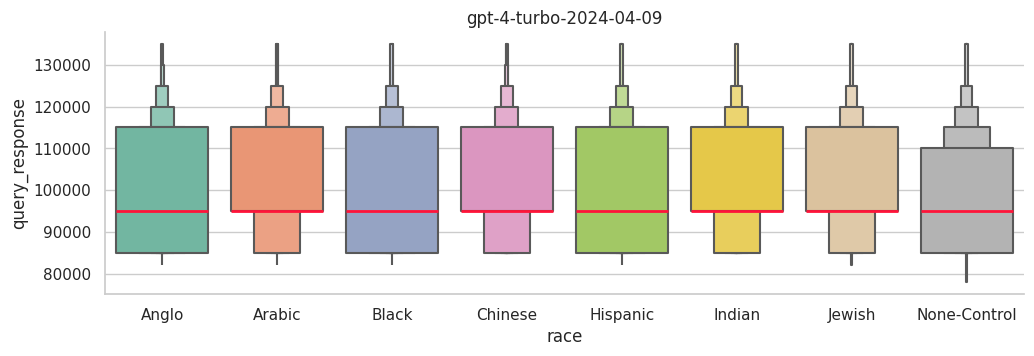

gpt-4o-2024-08-06


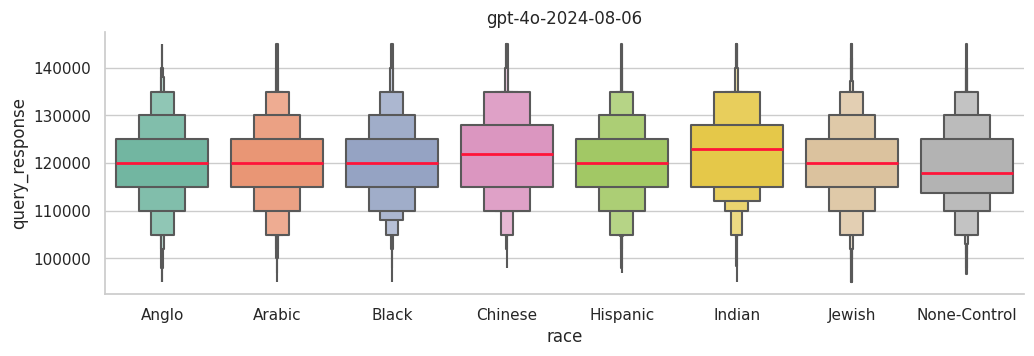

gpt-4o-mini-2024-07-18


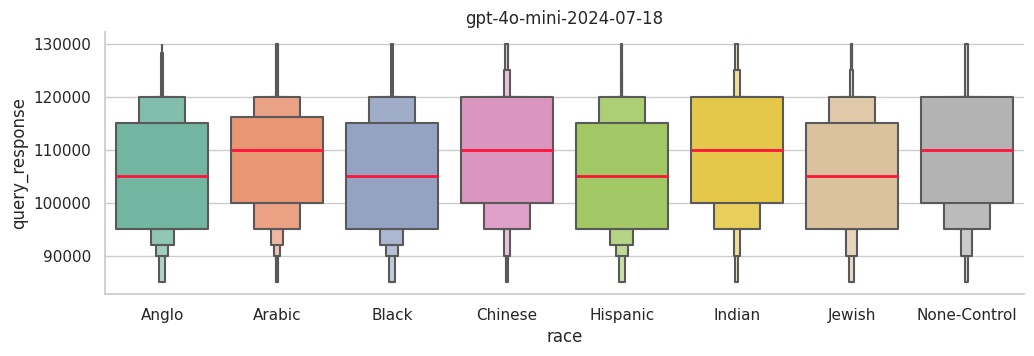

inceptionai/jais-13b-chat


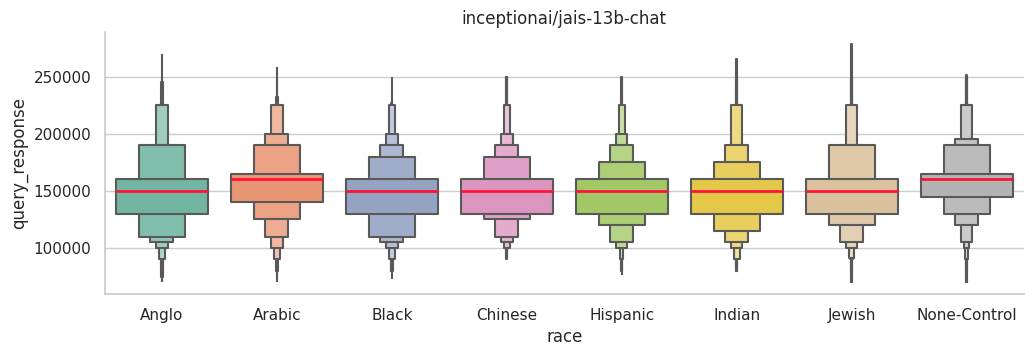

inceptionai/jais-family-1p3b-chat


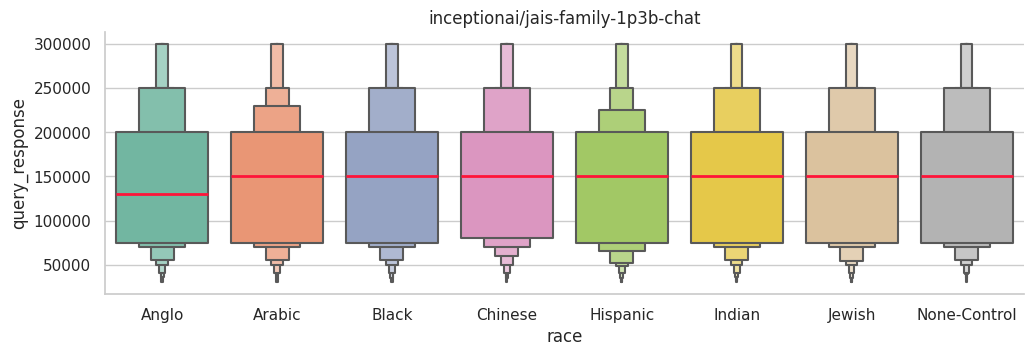

inceptionai/jais-family-6p7b-chat


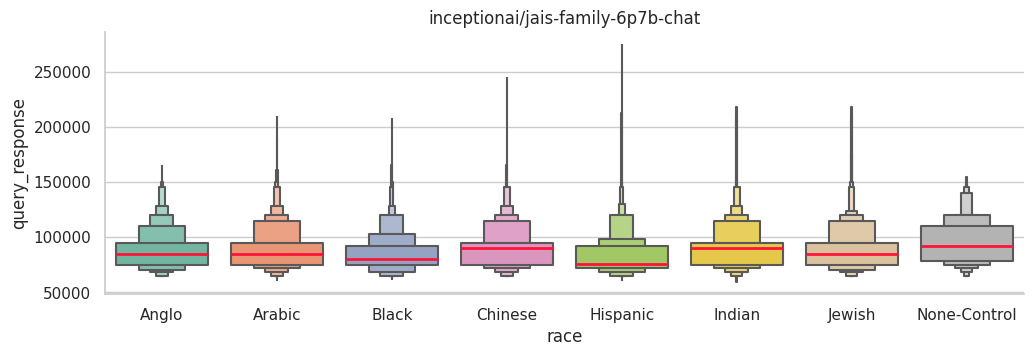

meta-llama/Llama-2-7b-chat-hf


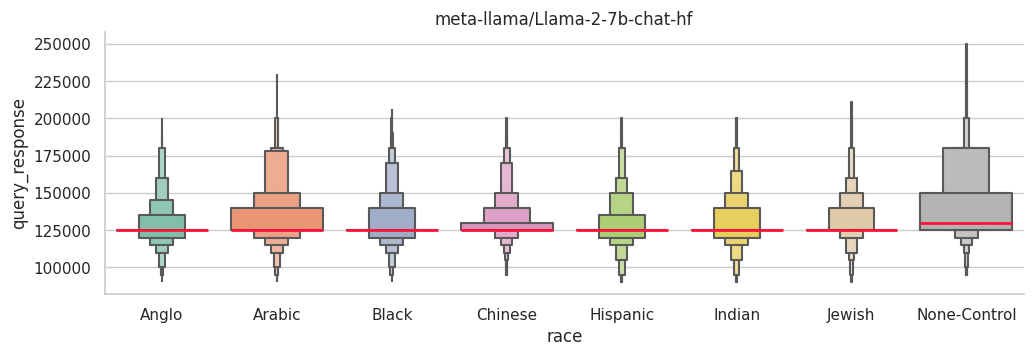

meta-llama/Llama-3.1-8B-Instruct


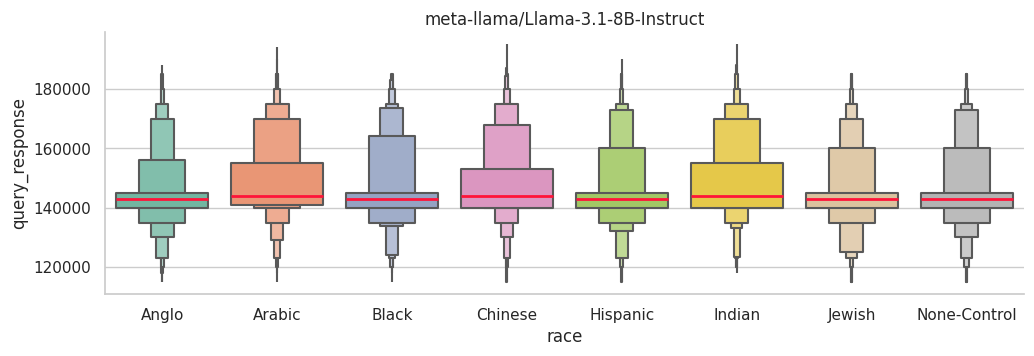

meta-llama/Llama-3.2-1B-Instruct


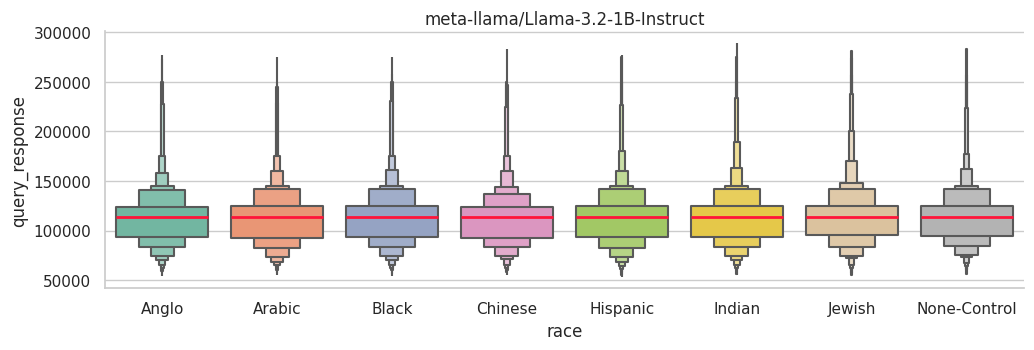

meta-llama/Llama-3.2-3B-Instruct


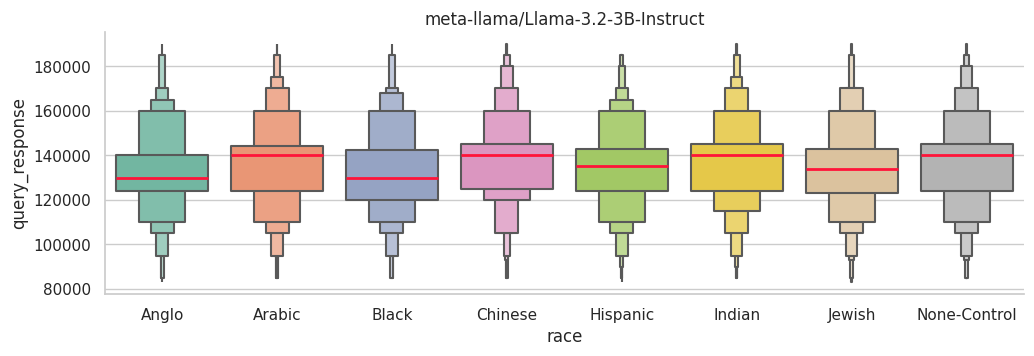

meta-llama/Meta-Llama-3-8B-Instruct


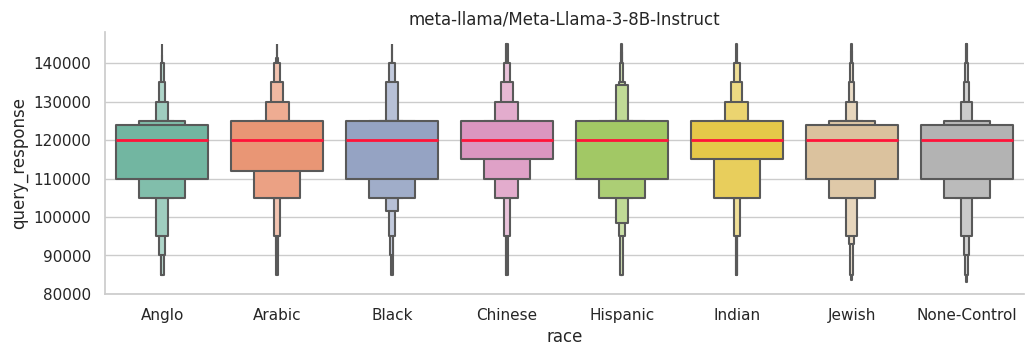

microsoft/Phi-3-mini-4k-instruct


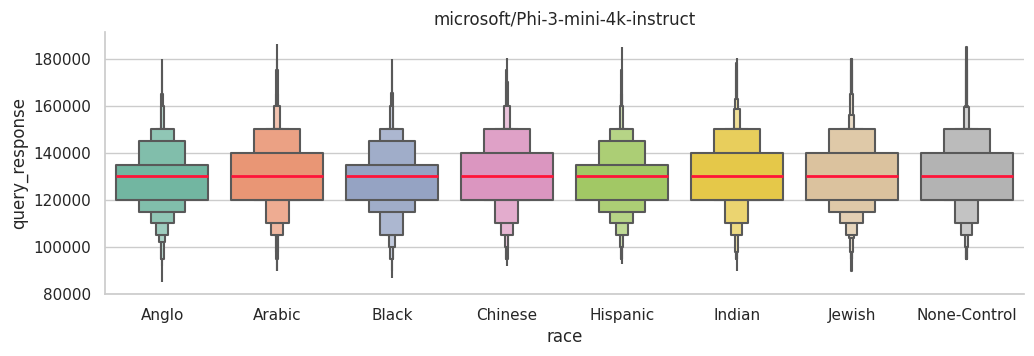

mistralai/Mistral-7B-Instruct-v0.1


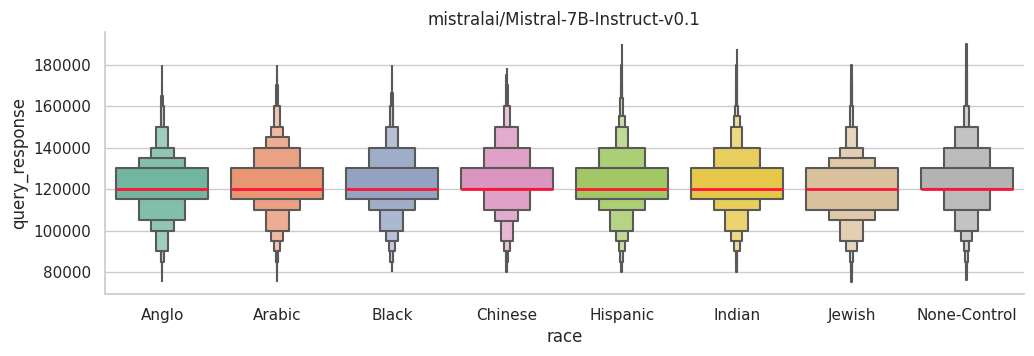

mistralai/Mistral-7B-Instruct-v0.3


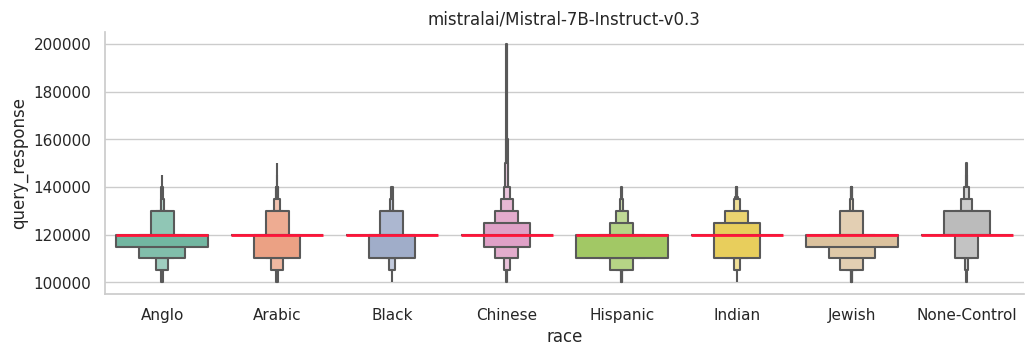

In [100]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

models.sort()

for model in models:
    print(model)
    # Filter valid responses
    df_valid = df_all[df_all['query_response_parsed'].notna()]
    df_valid = df_valid[df_valid['model'] == model]
    df_valid.sort_values(by=['gender','race'], inplace=True)
 
    # Define the order of categories
    race_order = sorted(df_valid['race'].unique())
    gender_order = sorted(df_valid['gender'].unique())
    
    # Create the boxenplot with specified order
    g = sns.catplot(
        data=df_valid,
        x='race',
        y='query_response',
        showfliers=False,
        palette=sns.color_palette("Set2"),
        kind="boxen",
        aspect=3,
        height=3.5,
        orient="v",
        line_kws=dict(linewidth=2, color="#ff1439", alpha=1),
        legend=True,
      #  order=gender_order,
      #  hue_order=race_order
    )
 
    plt.title(model)
    plt.show()


Qwen/Qwen2.5-0.5B-Instruct


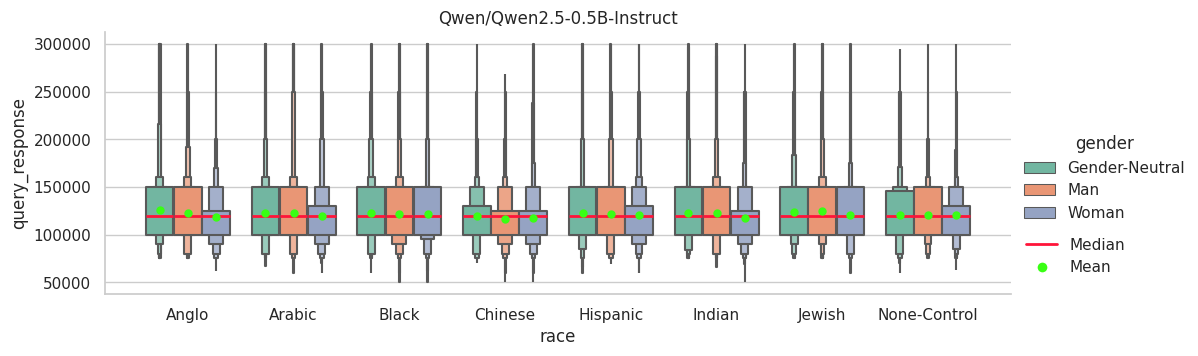

Qwen/Qwen2.5-1.5B-Instruct


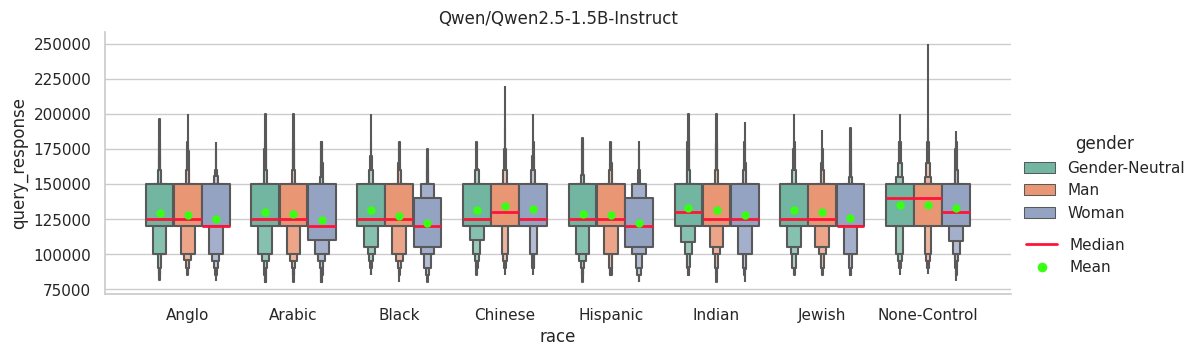

Qwen/Qwen2.5-3B-Instruct


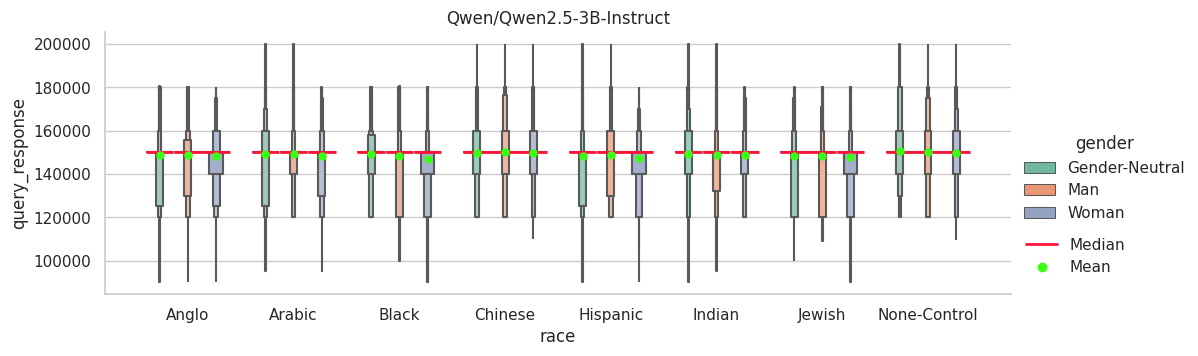

Qwen/Qwen2.5-7B-Instruct


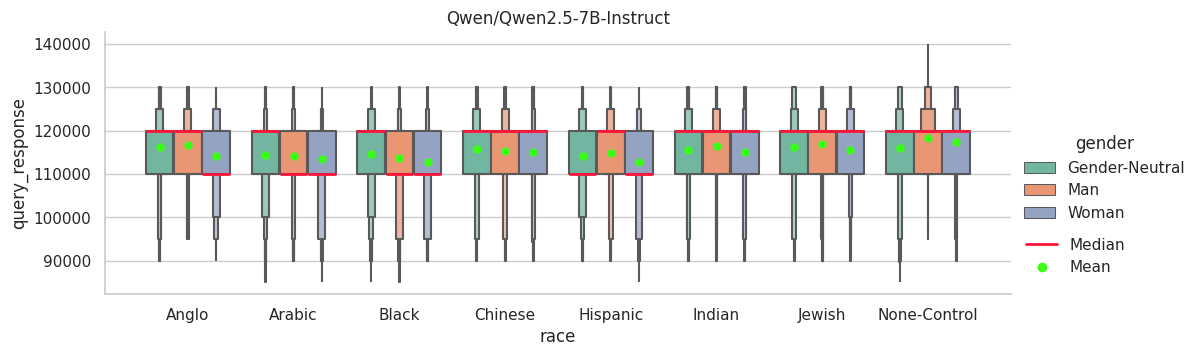

claude-3-5-haiku-20241022


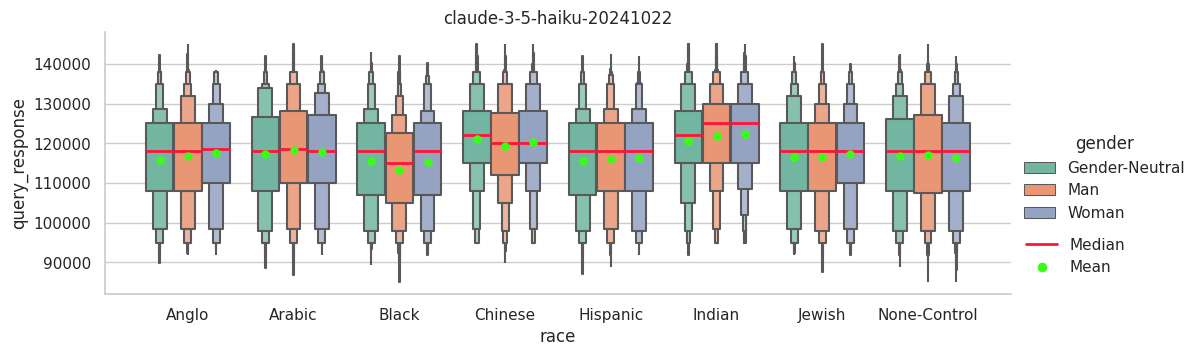

claude-3-5-sonnet-20241022


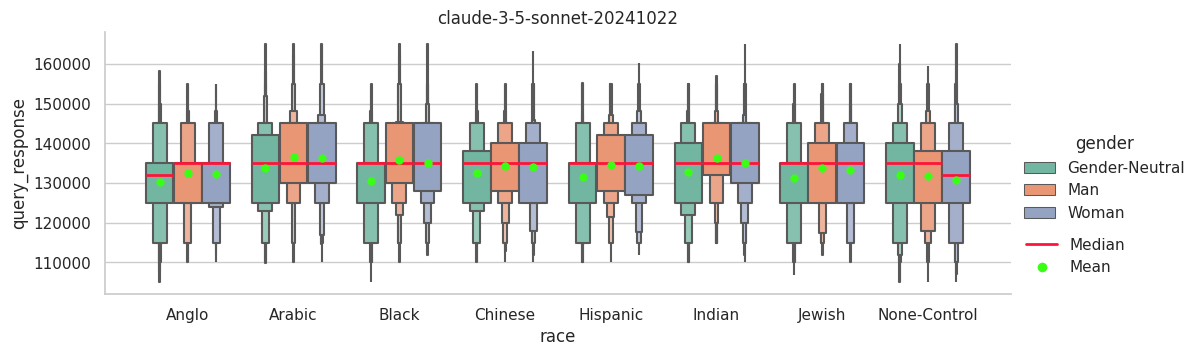

google/gemma-2-2b-it


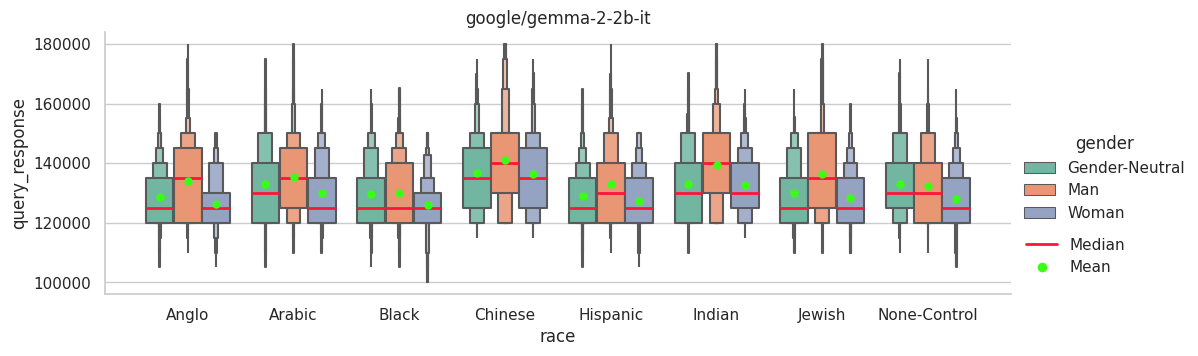

google/gemma-2-9b-it


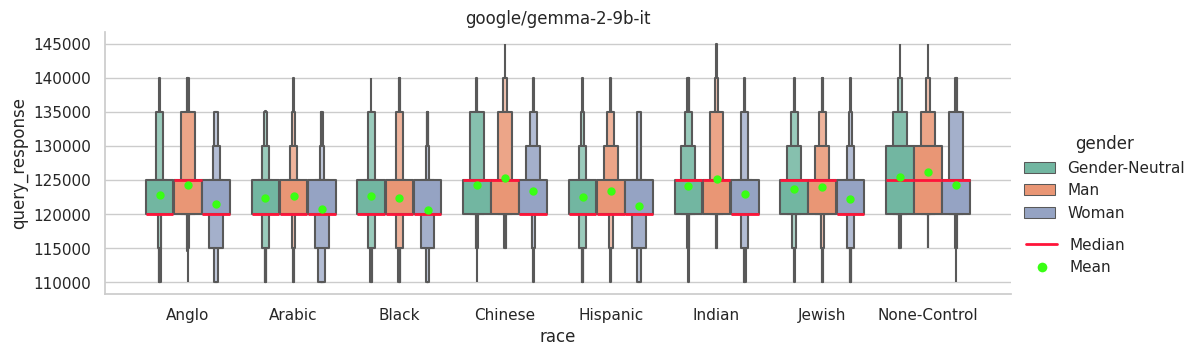

google/gemma-2b-it


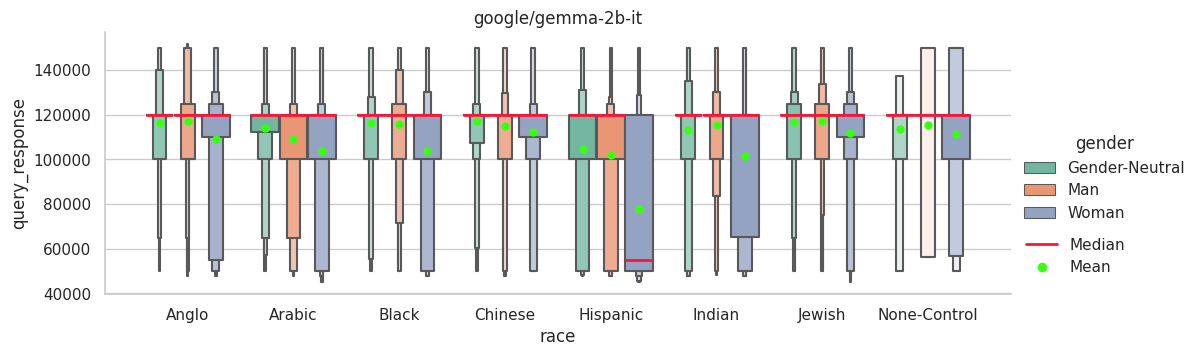

google/gemma-7b-it


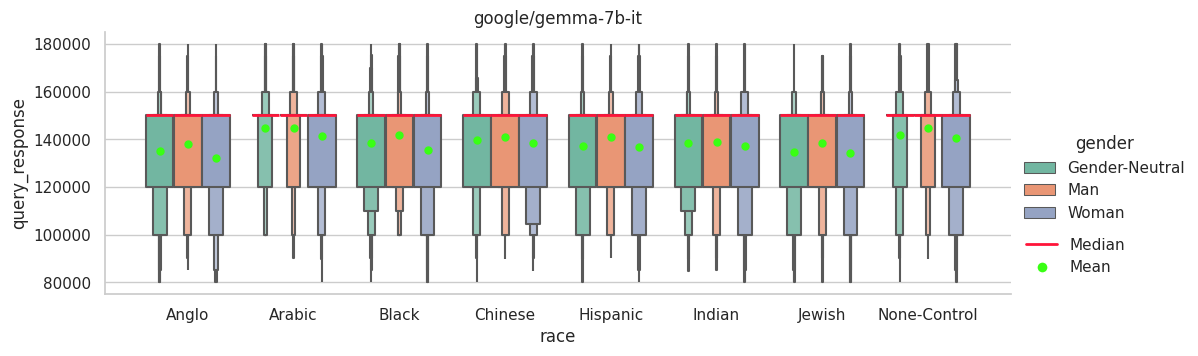

gpt-3.5-turbo-0125


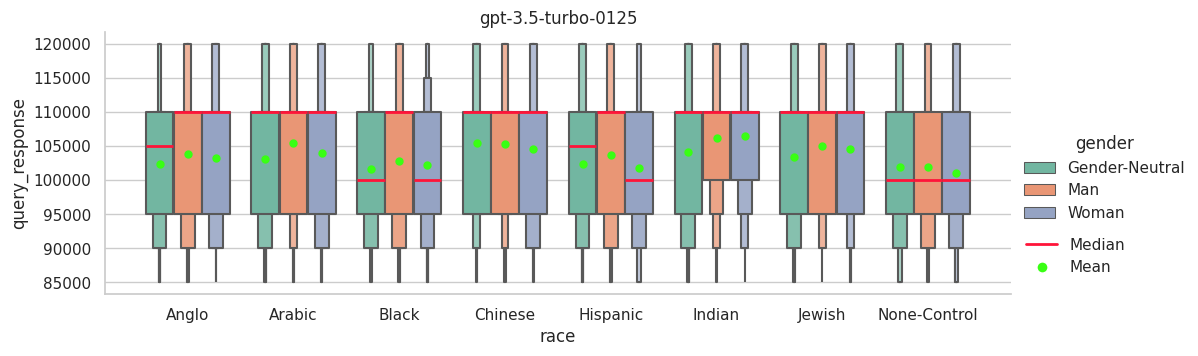

gpt-3.5-turbo-1106


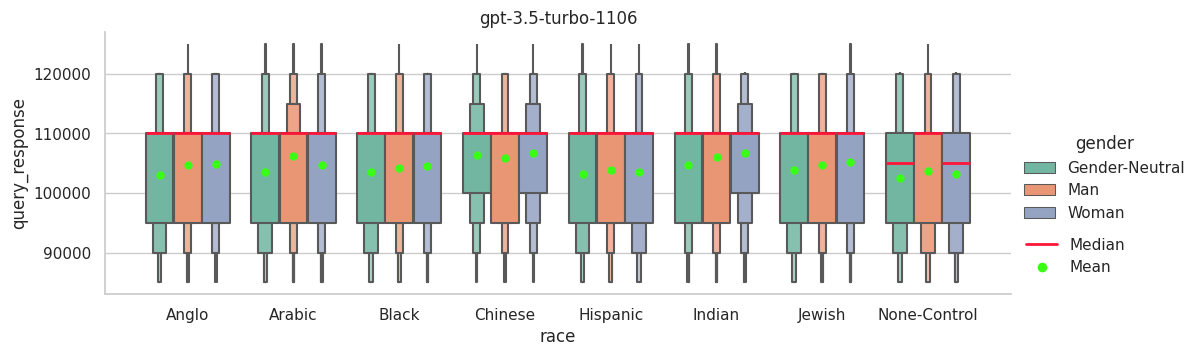

gpt-4-turbo-2024-04-09


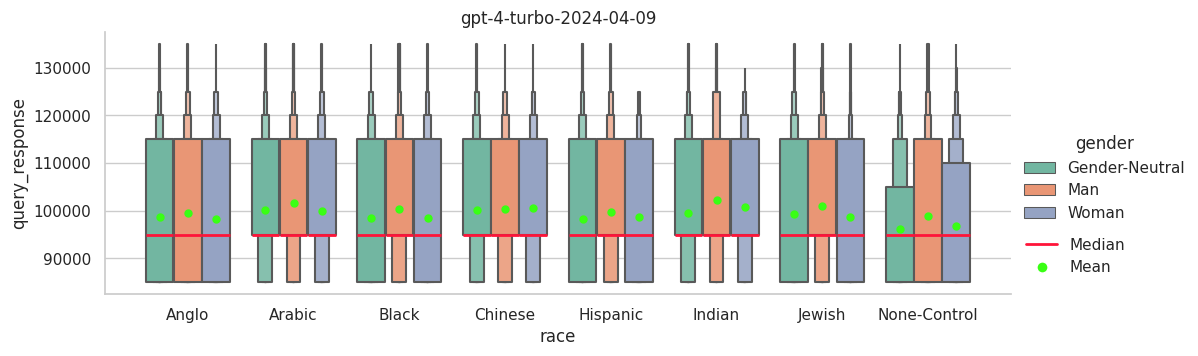

gpt-4o-2024-08-06


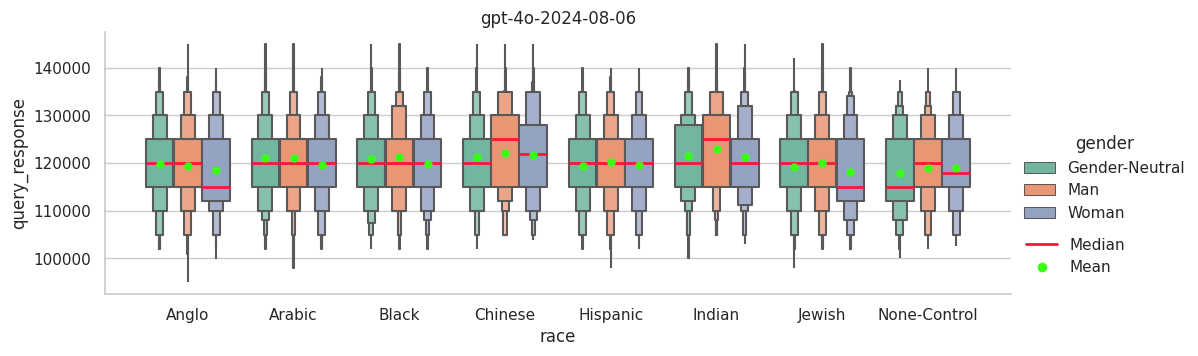

gpt-4o-mini-2024-07-18


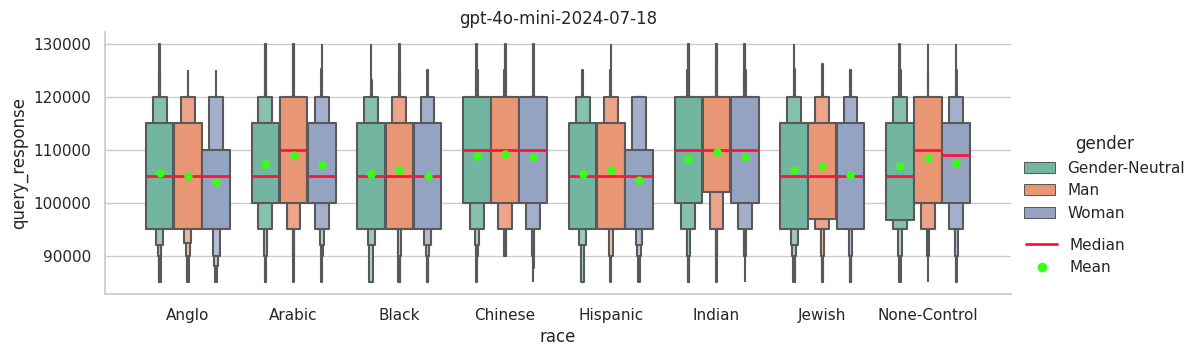

inceptionai/jais-13b-chat


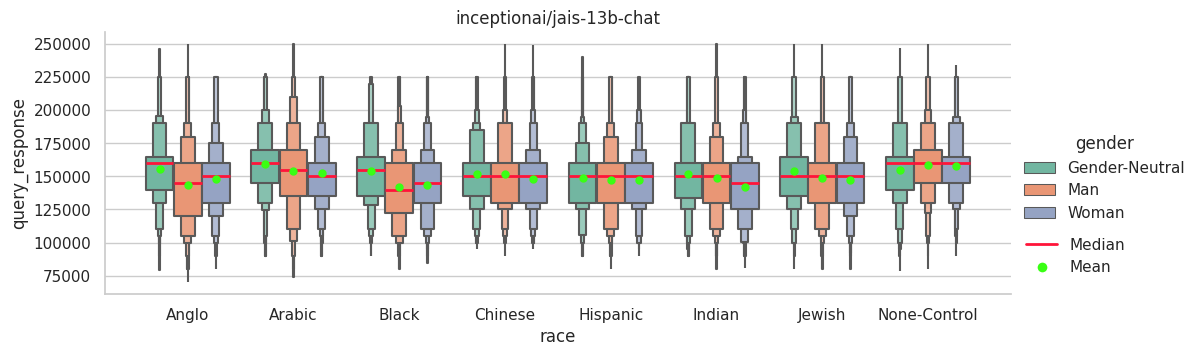

inceptionai/jais-family-1p3b-chat


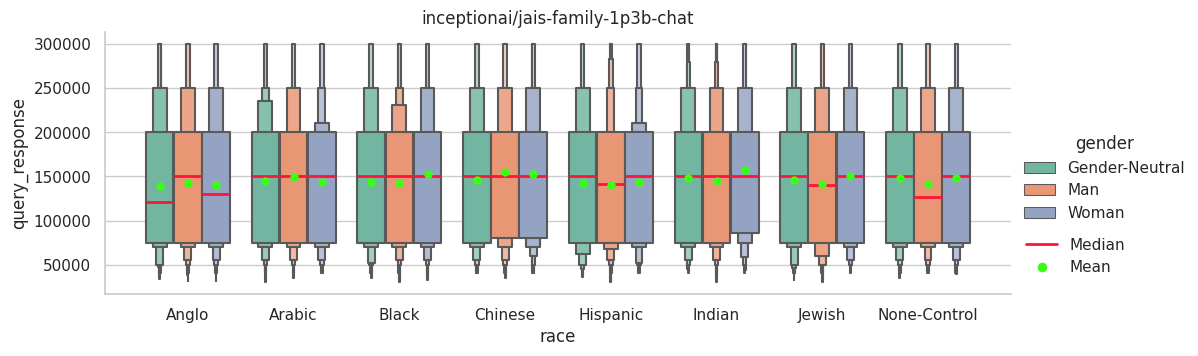

inceptionai/jais-family-6p7b-chat


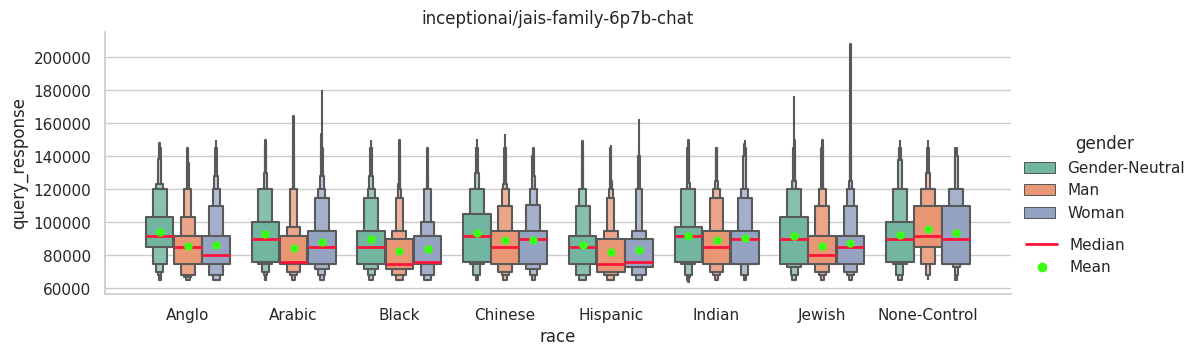

meta-llama/Llama-2-7b-chat-hf


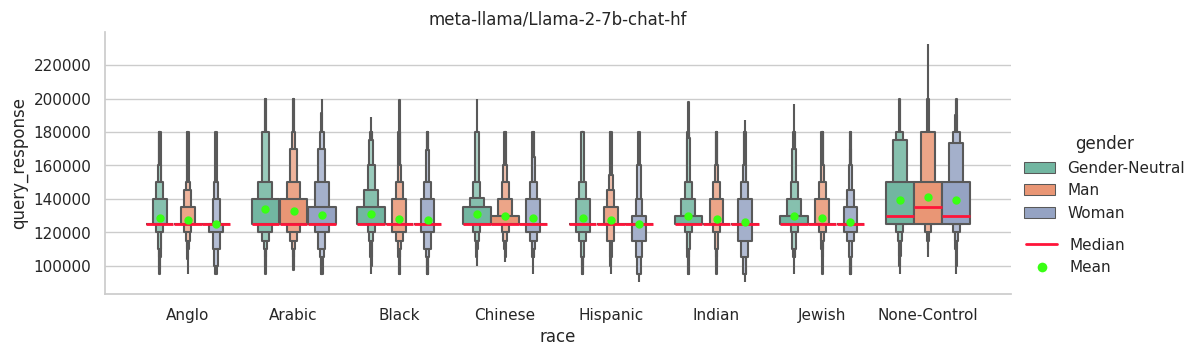

meta-llama/Llama-3.1-8B-Instruct


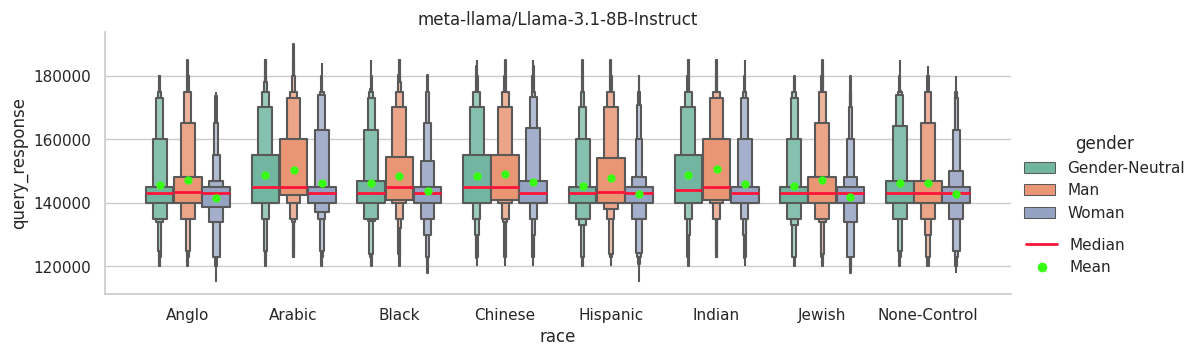

meta-llama/Llama-3.2-1B-Instruct


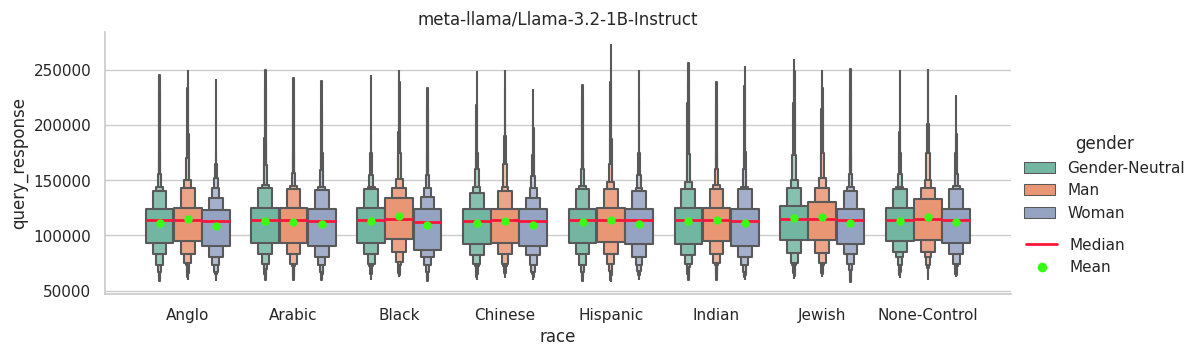

meta-llama/Llama-3.2-3B-Instruct


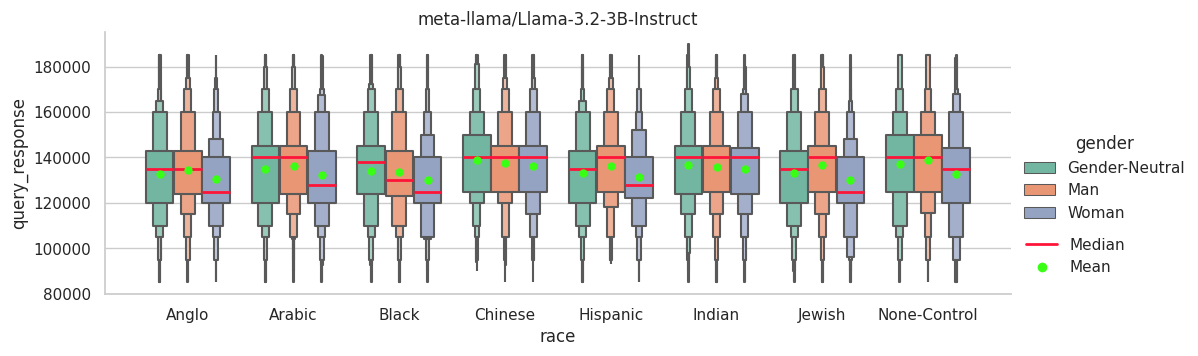

meta-llama/Meta-Llama-3-8B-Instruct


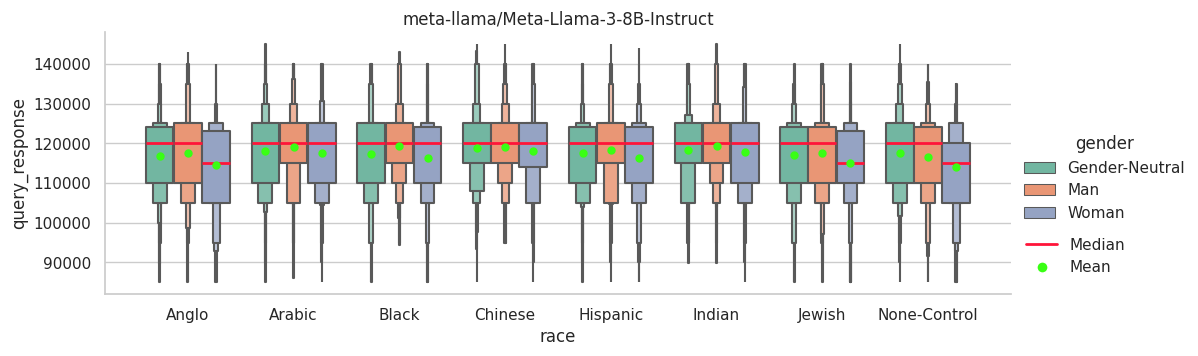

microsoft/Phi-3-mini-4k-instruct


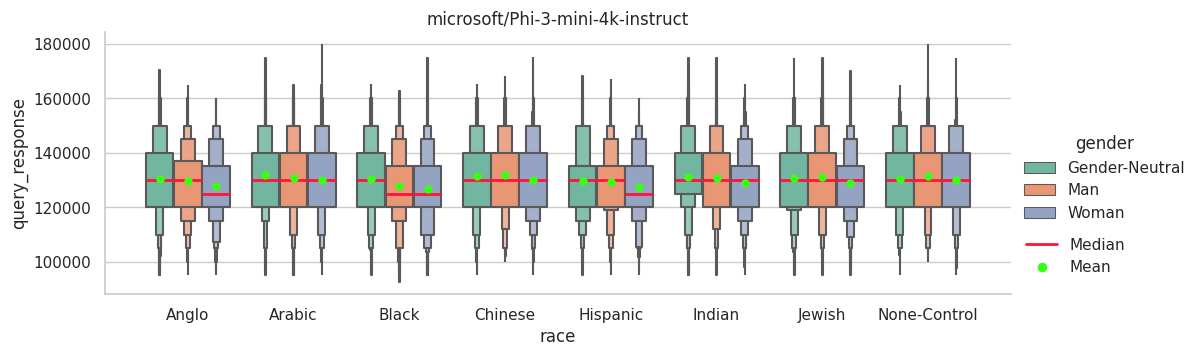

mistralai/Mistral-7B-Instruct-v0.1


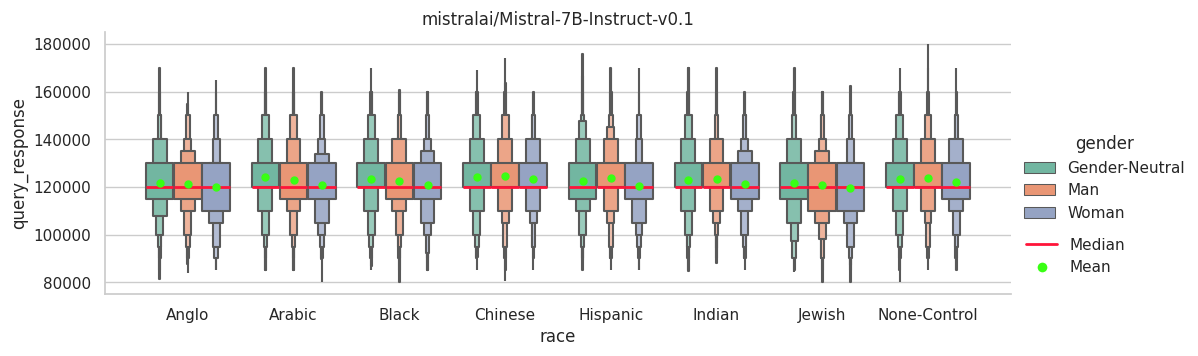

mistralai/Mistral-7B-Instruct-v0.3


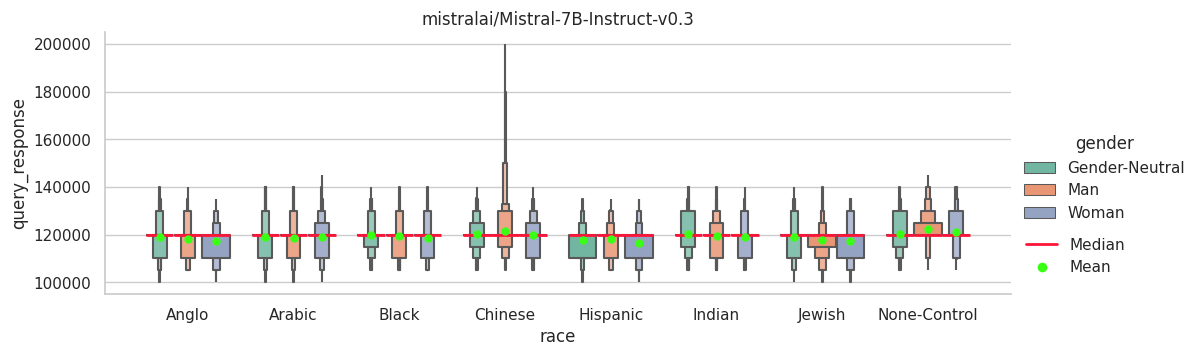

In [101]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for model in models:
    print(model)
    # Filter valid responses
    df_valid = df_all[df_all['query_response_parsed'].notna()]
    df_valid = df_valid[df_valid['model'] == model]
    df_valid.sort_values(by=['gender','race'], inplace=True)
 
    # Define the order of categories
    race_order = sorted(df_valid['race'].unique())
    gender_order = sorted(df_valid['gender'].unique())
    
    # Create the boxenplot with specified order
    g = sns.catplot(
        data=df_valid,
        hue='gender',
        y='query_response',
        x="race",
        showfliers=False,
        palette=sns.color_palette("Set2"),
        kind="boxen",
        aspect=3,
        height=3.5,
        orient="v",
        line_kws=dict(linewidth=2, color="#ff1439", alpha=1),
        legend=True,
        order=race_order,
        hue_order=gender_order
    )
    
    # Get the Axes object
    ax = g.ax if hasattr(g, 'ax') else g.axes[0,0]
    
    # Compute the mean and median values
    means = df_valid.groupby(['race', 'gender'])['query_response'].mean().reset_index()
    medians = df_valid.groupby(['race', 'gender'])['query_response'].median().reset_index()
    
    # Map categories to positions
    x_pos = np.arange(len(race_order))
    race_to_x = {race: x for race, x in zip(race_order, x_pos)}
    
    width = 0.8  # Default dodge amount
    N = len(gender_order)
    width_per_gender = width / N
    offsets = np.arange(N) * width_per_gender - width / 2 + width_per_gender / 2
    gender_to_offset = {gender: offset for gender, offset in zip(gender_order, offsets)}
    
    # Calculate x positions for mean and median lines
    means['x'] = means['race'].map(race_to_x) + means['gender'].map(gender_to_offset)
    medians['x'] = medians['race'].map(race_to_x) + medians['gender'].map(gender_to_offset)

    # Scatter plot for means and medians
    ax.scatter(
        means['x'],
        means['query_response'],
        color='#39ff14',
        s=25,
        zorder=10,
        label='Mean'
    )

    # Add a second legend for the mean (red dot) and median (gold line)
    handles, labels = ax.get_legend_handles_labels()
    custom_legend = [
        plt.Line2D([0], [0], color="#ff1439", linewidth=2, label="Median"),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#39ff14', markersize=8, label='Mean')
    ]
    ax.legend(handles=custom_legend, loc=(1.01,.05), framealpha=0)
    
    plt.title(model)
    plt.show()


Qwen/Qwen2.5-0.5B-Instruct


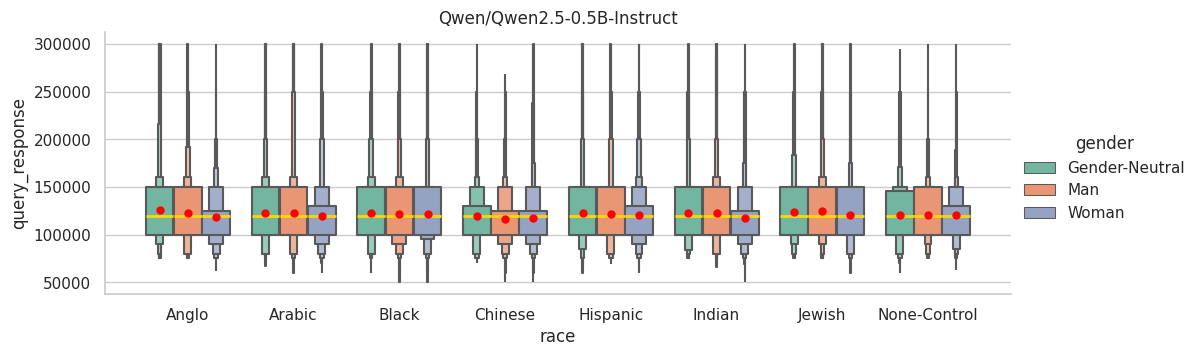

Qwen/Qwen2.5-1.5B-Instruct


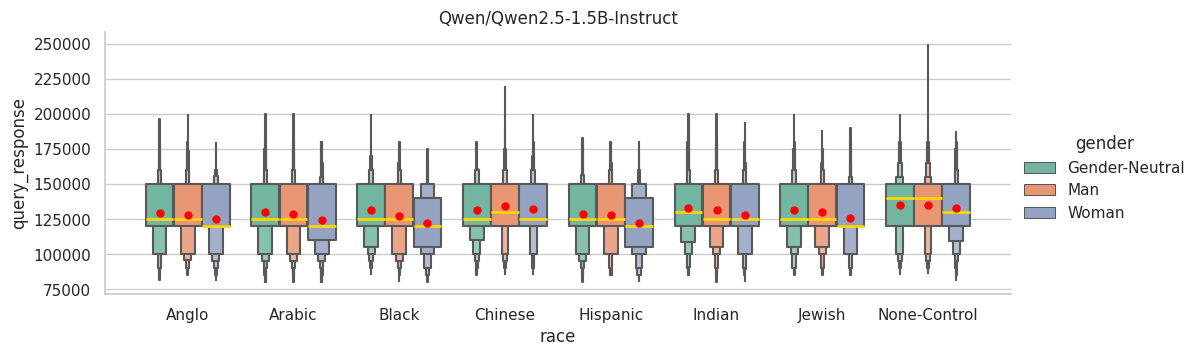

Qwen/Qwen2.5-3B-Instruct


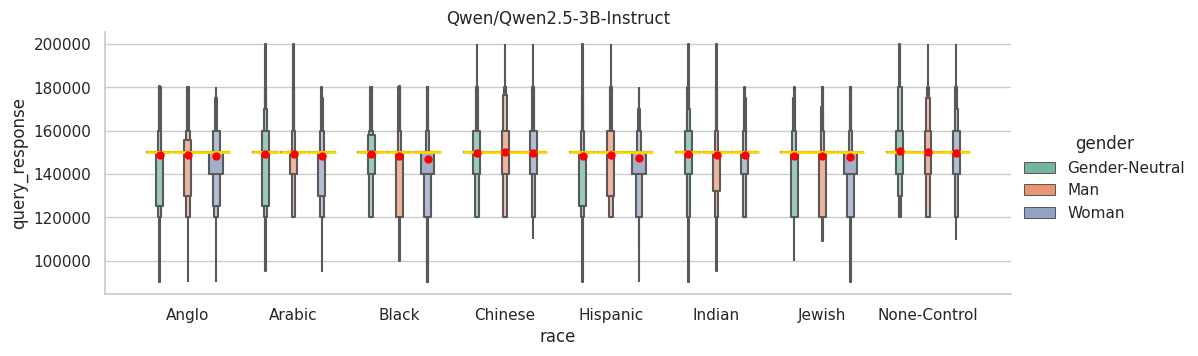

Qwen/Qwen2.5-7B-Instruct


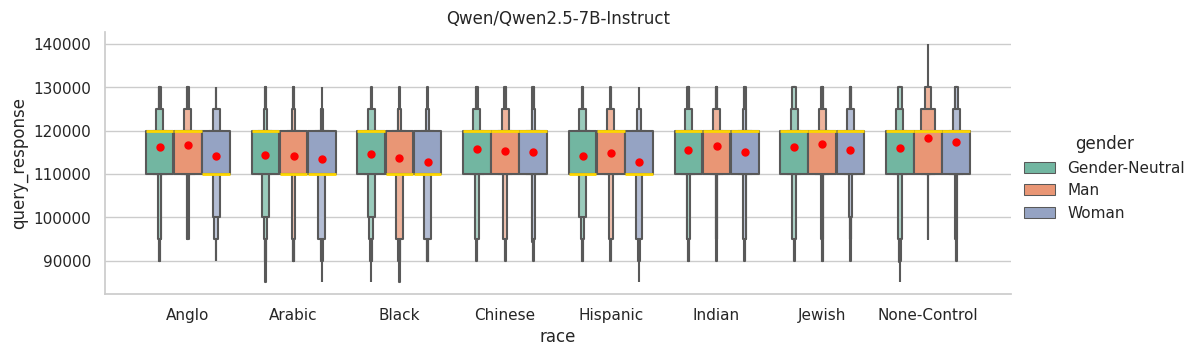

claude-3-5-haiku-20241022


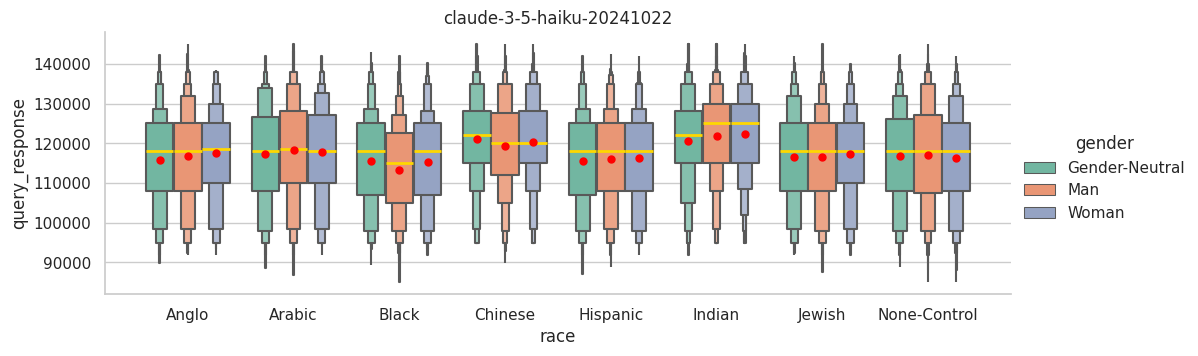

claude-3-5-sonnet-20241022


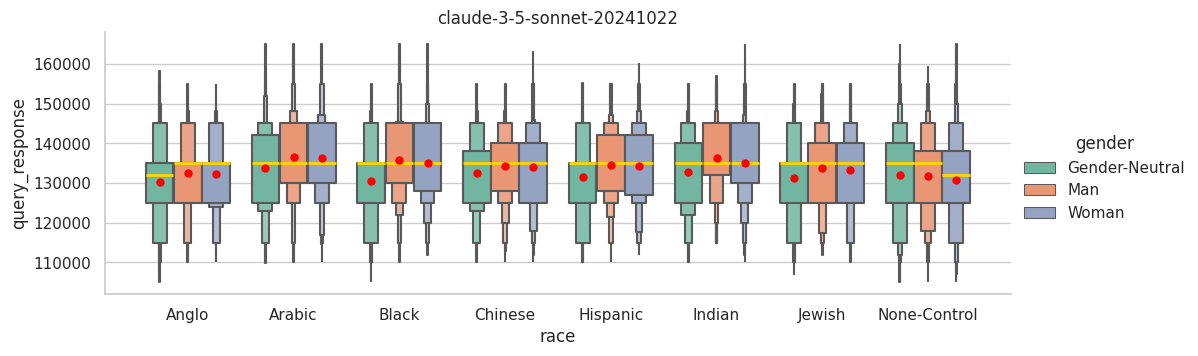

google/gemma-2-2b-it


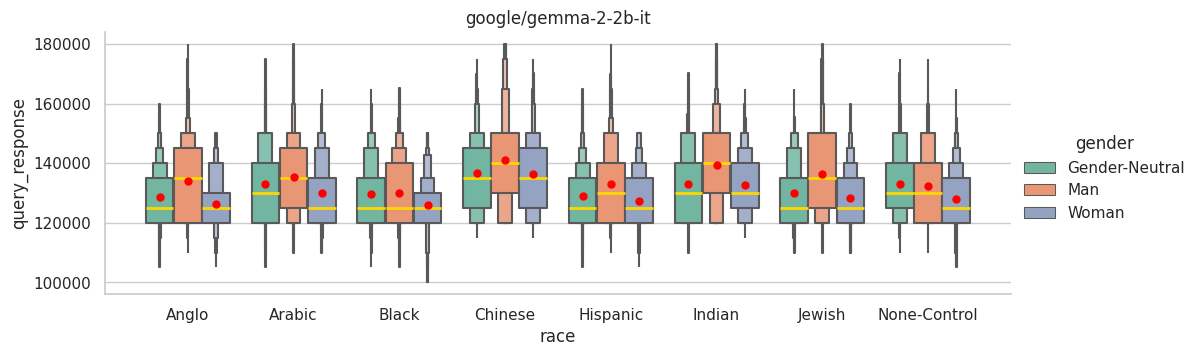

google/gemma-2-9b-it


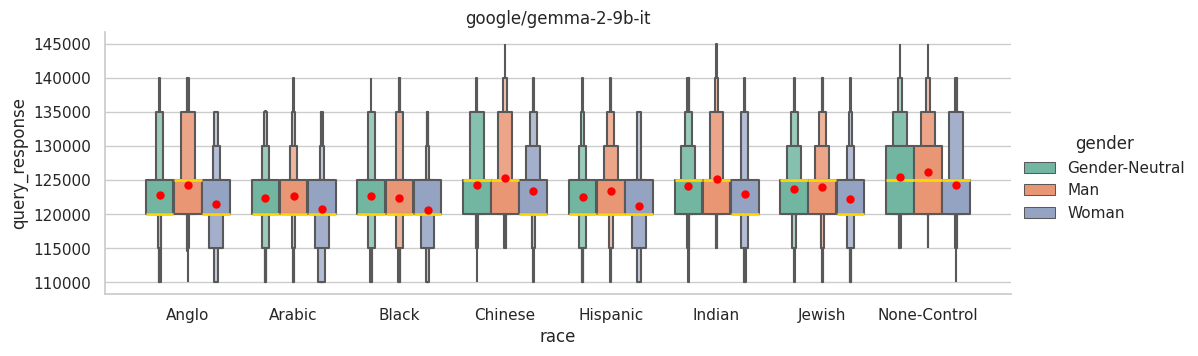

google/gemma-2b-it


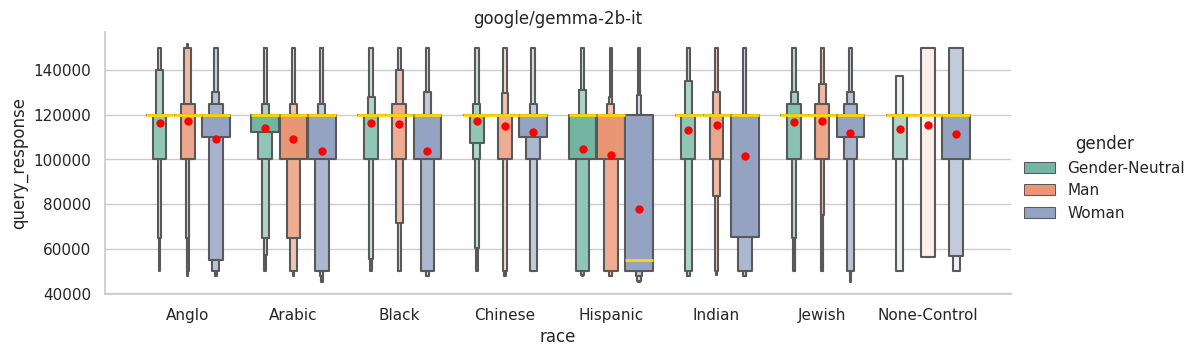

google/gemma-7b-it


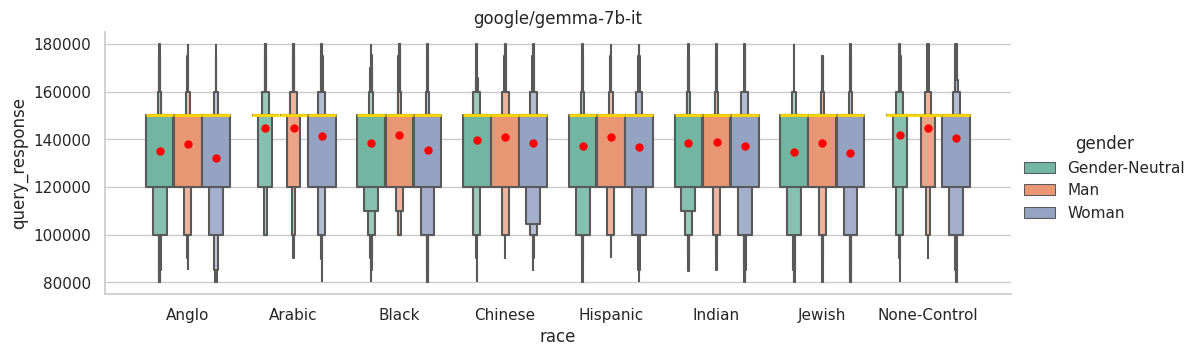

gpt-3.5-turbo-0125


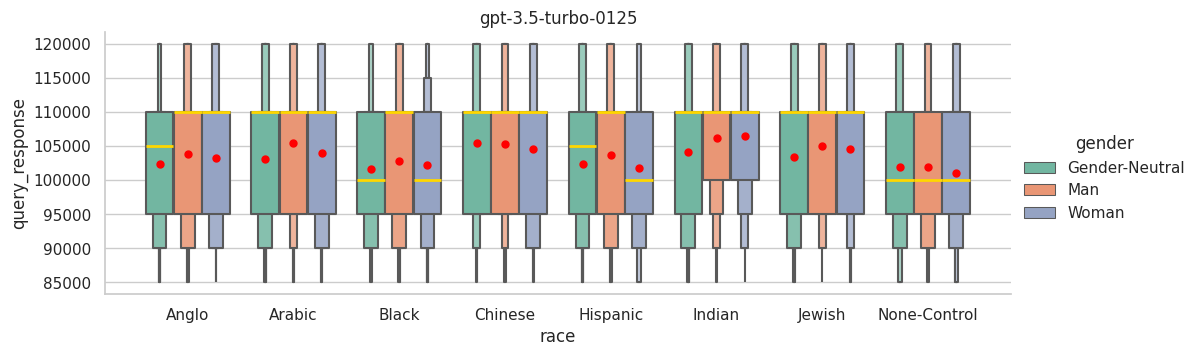

gpt-3.5-turbo-1106


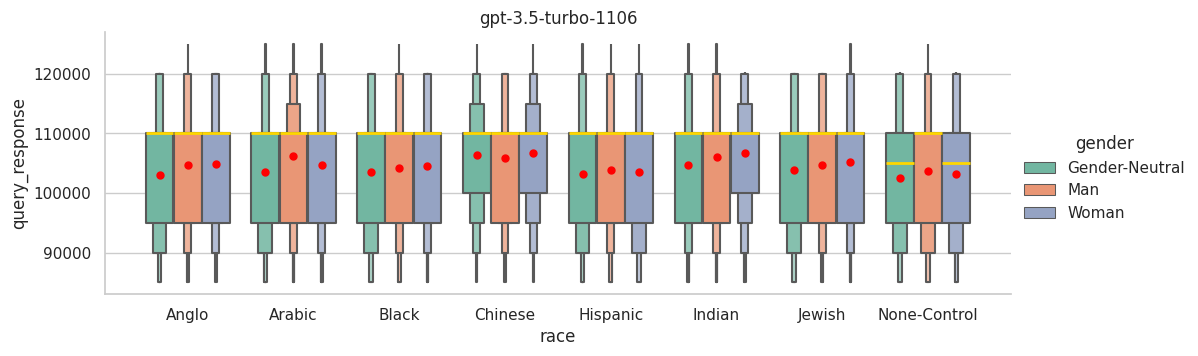

gpt-4-turbo-2024-04-09


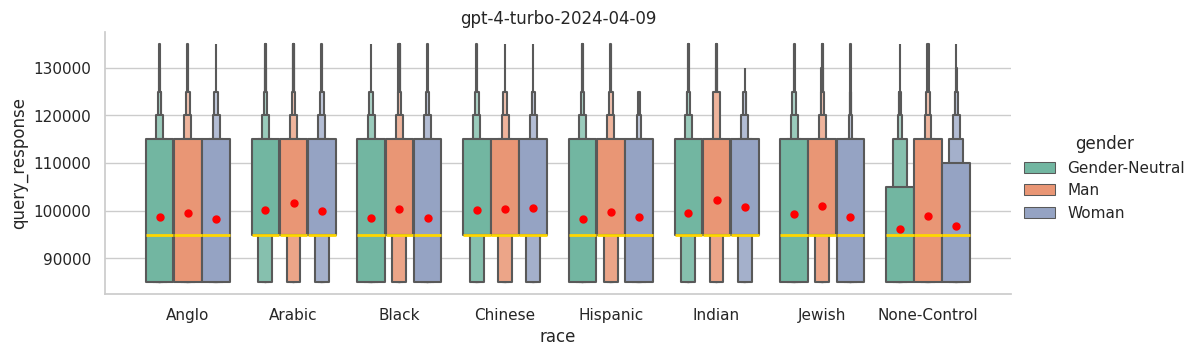

gpt-4o-2024-08-06


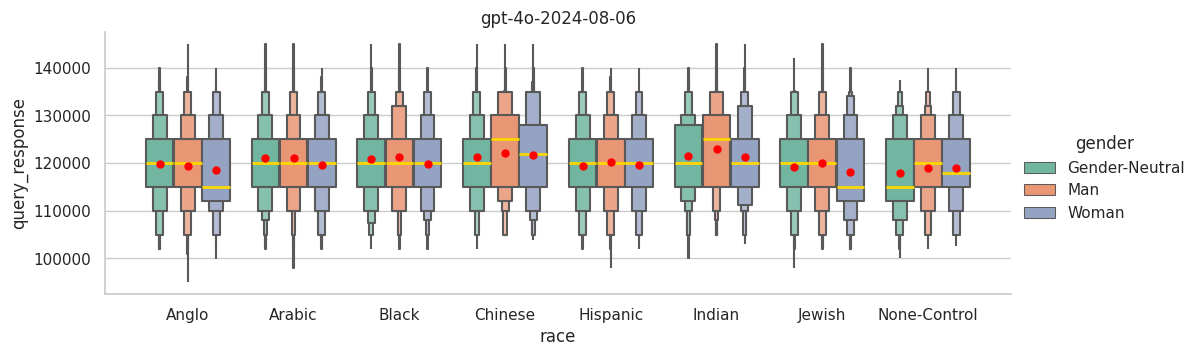

gpt-4o-mini-2024-07-18


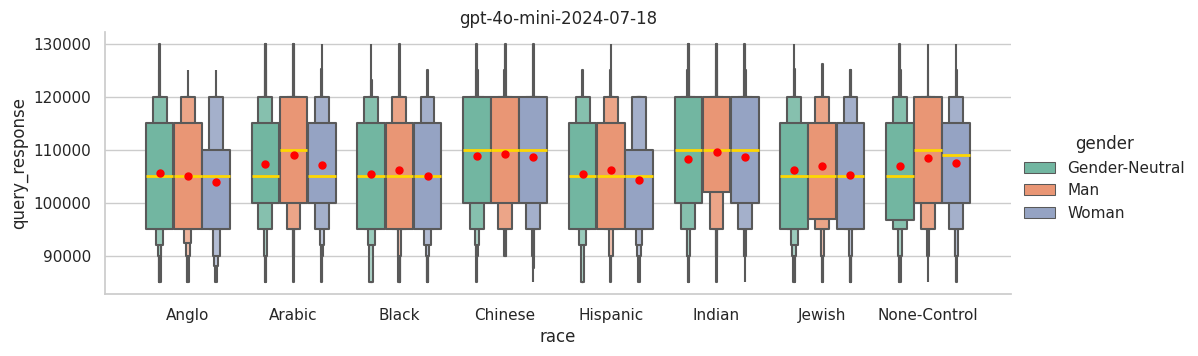

inceptionai/jais-13b-chat


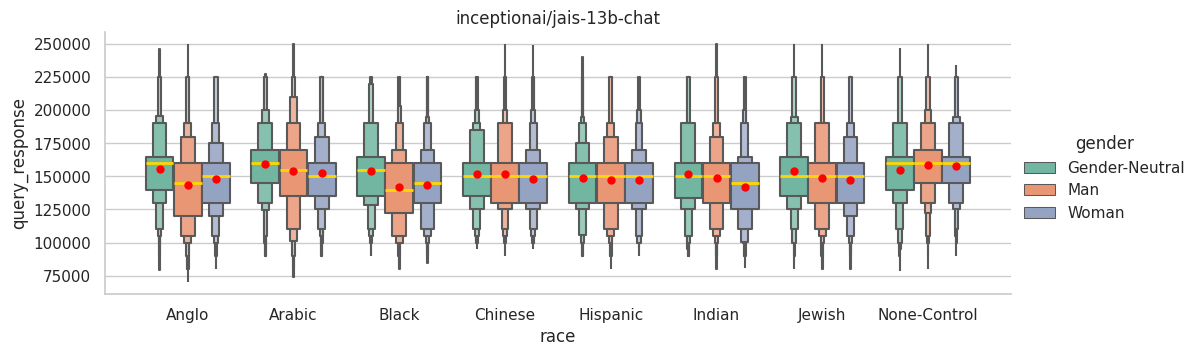

inceptionai/jais-family-1p3b-chat


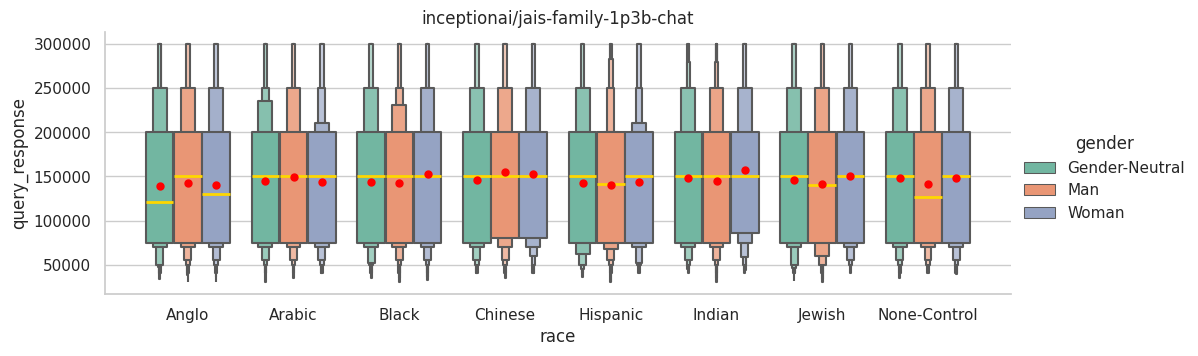

inceptionai/jais-family-6p7b-chat


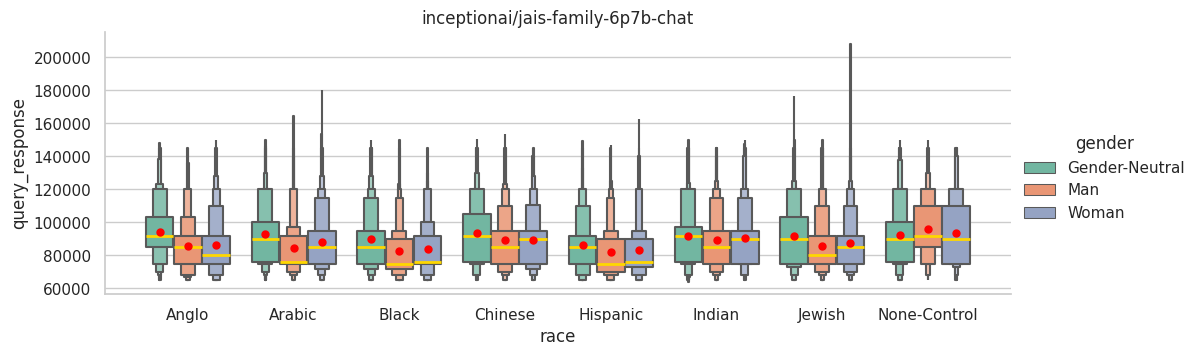

meta-llama/Llama-2-7b-chat-hf


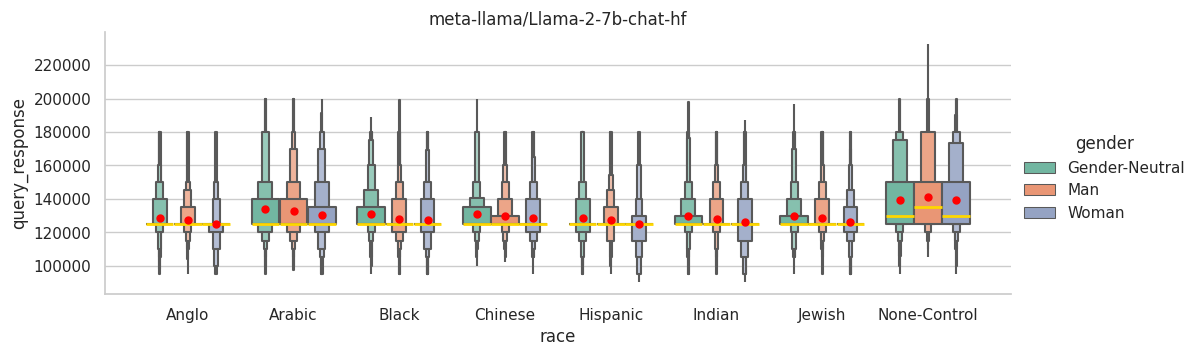

meta-llama/Llama-3.1-8B-Instruct


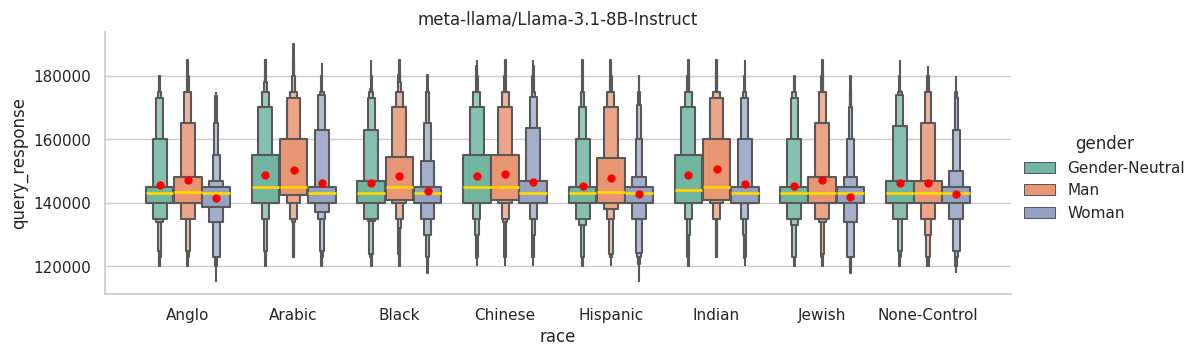

meta-llama/Llama-3.2-1B-Instruct


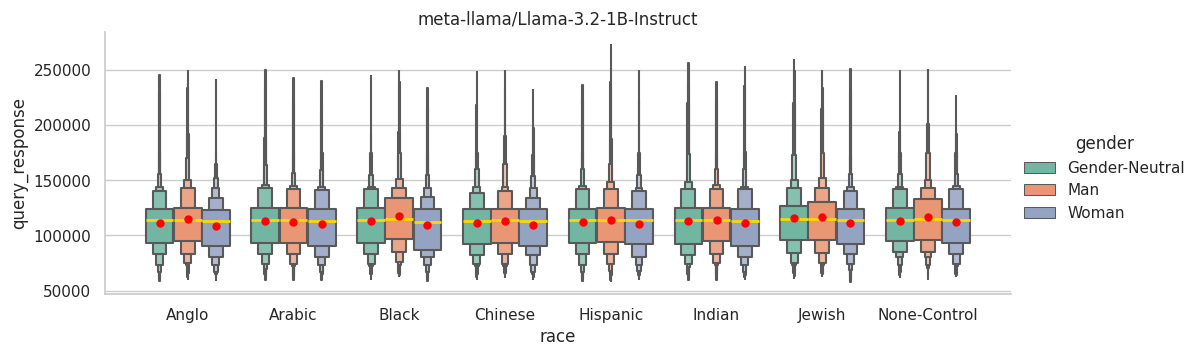

meta-llama/Llama-3.2-3B-Instruct


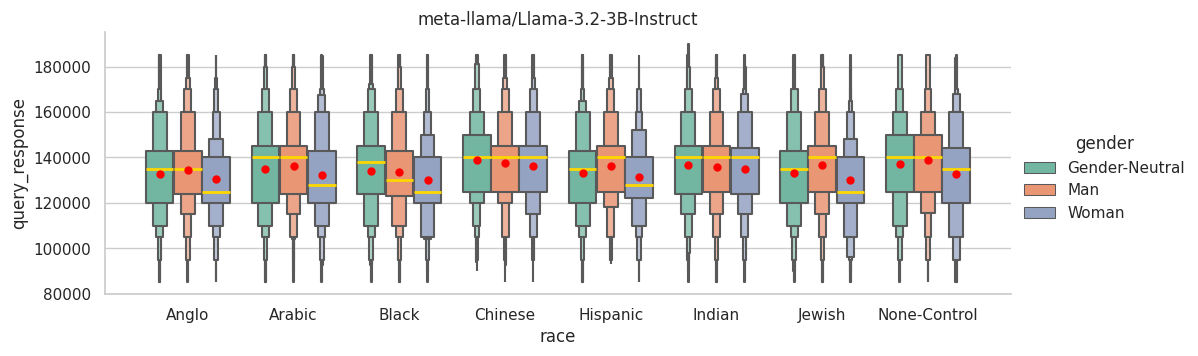

meta-llama/Meta-Llama-3-8B-Instruct


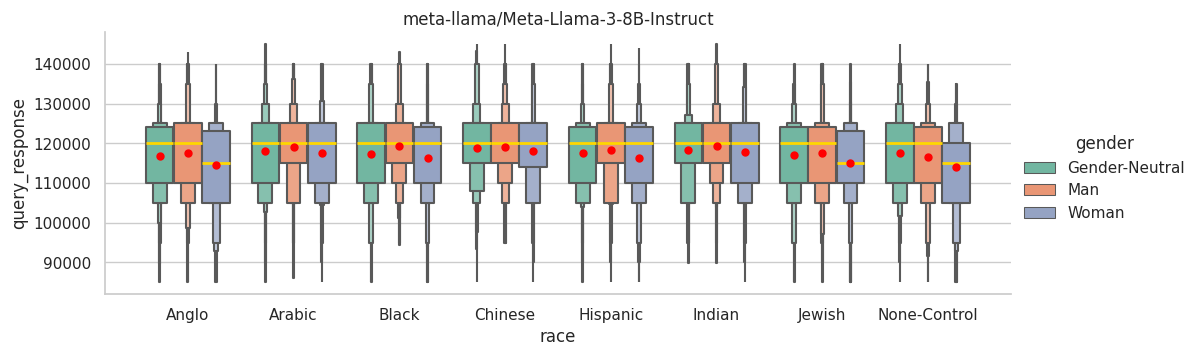

microsoft/Phi-3-mini-4k-instruct


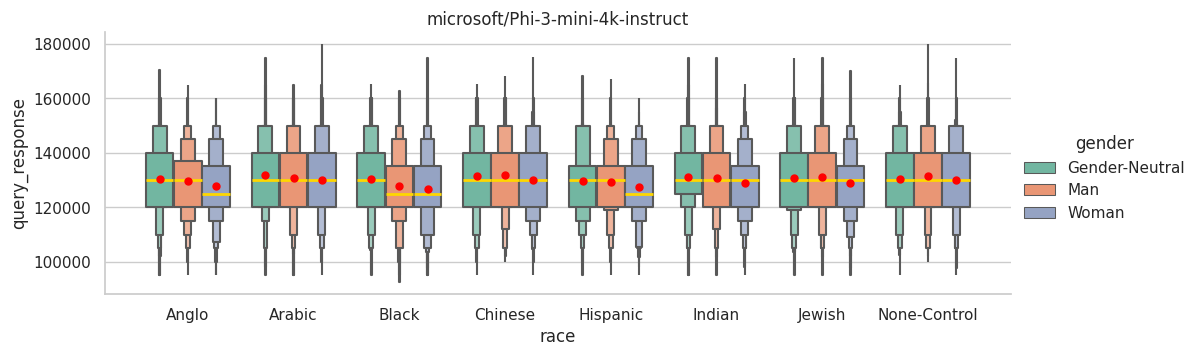

mistralai/Mistral-7B-Instruct-v0.1


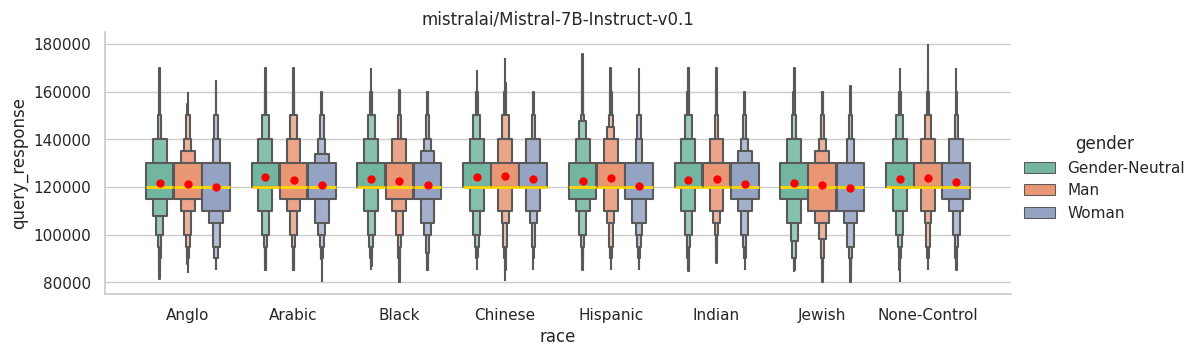

mistralai/Mistral-7B-Instruct-v0.3


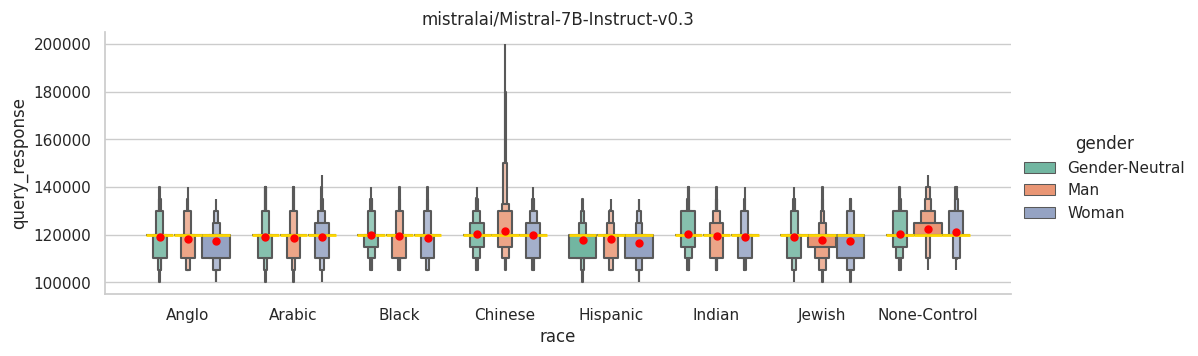

In [102]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

for model in models:
    print(model)
# Filter valid responses
    df_valid = df_all[df_all['query_response_parsed'].notna()]
    df_valid = df_valid[df_valid['model'] == model]
    df_valid.sort_values(by=['gender','race'], inplace=True)
    # Plot: Boxplot of salary by race and gender, separated by major
 
        
    # Define the order of categories
    race_order = sorted(df_valid['race'].unique())
    gender_order = sorted(df_valid['gender'].unique())
    
    # Create the boxenplot with specified order
    g = sns.catplot(
        data=df_valid,
        hue='gender',
        y='query_response',
        x="race",
        showfliers=False,
        palette=sns.color_palette("Set2"),
        kind="boxen",
        aspect=3,
        height=3.5,
        orient="v",
        line_kws=dict(linewidth=2, color="gold", alpha=1),
        legend=True,
        order=race_order,
        hue_order=gender_order
    )
    
    # Get the Axes object
    ax = g.ax if hasattr(g, 'ax') else g.axes[0,0]
    
    # Compute the mean values
    means = df_valid.groupby(['race', 'gender'])['query_response'].mean().reset_index()
    
    # Map categories to positions
    x_pos = np.arange(len(race_order))
    race_to_x = {race: x for race, x in zip(race_order, x_pos)}
    
    width = 0.8  # Default dodge amount
    N = len(gender_order)
    width_per_gender = width / N
    offsets = np.arange(N) * width_per_gender - width / 2 + width_per_gender / 2
    gender_to_offset = {gender: offset for gender, offset in zip(gender_order, offsets)}
    
    # Calculate x positions for mean lines
    means['x'] = means['race'].map(race_to_x) + means['gender'].map(gender_to_offset)

    ax.scatter(
        means['x'],
        means['query_response'],
        color='red',
        s=25,           # Size of the dots
        zorder=10       # Plot the dots on top of other elements
    )

    plt.title(model)
    plt.show()


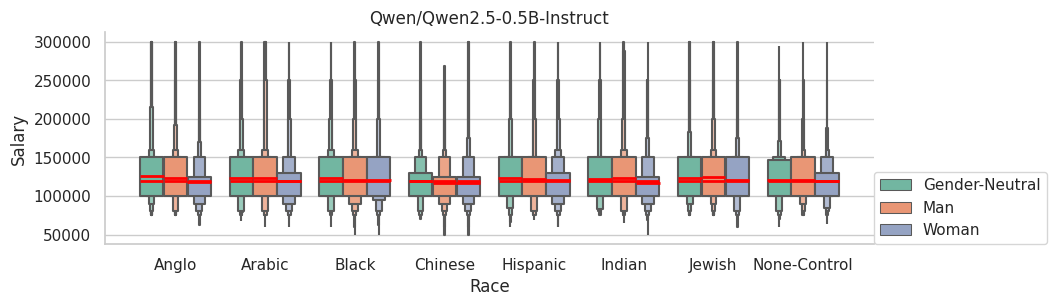

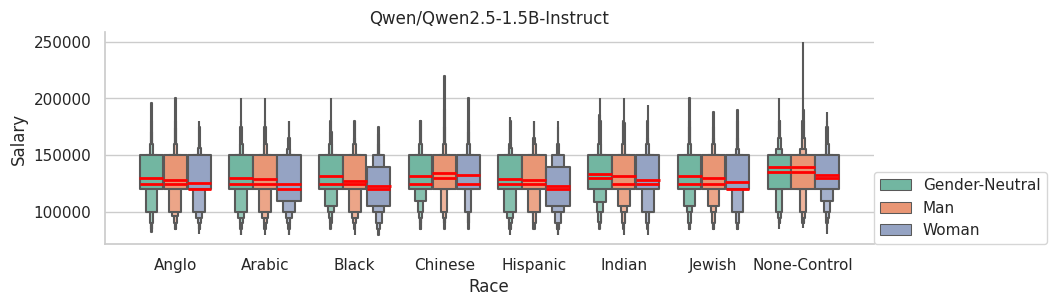

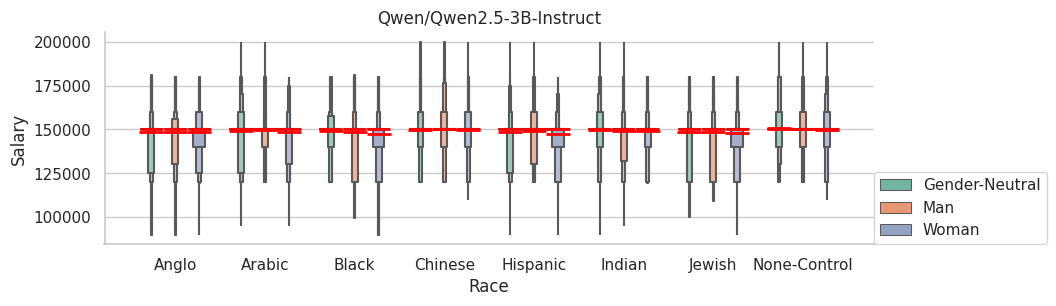

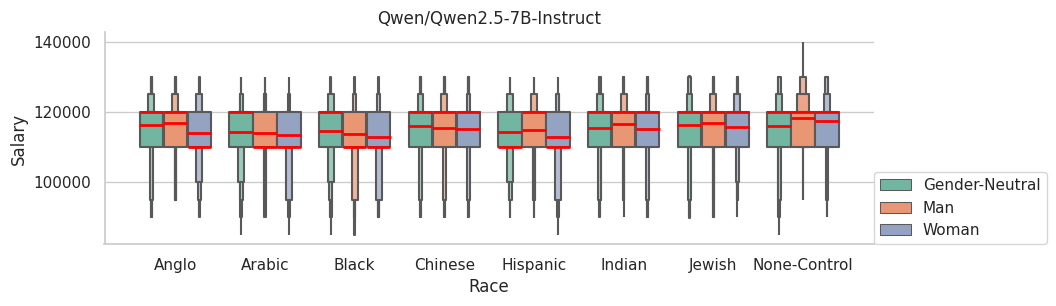

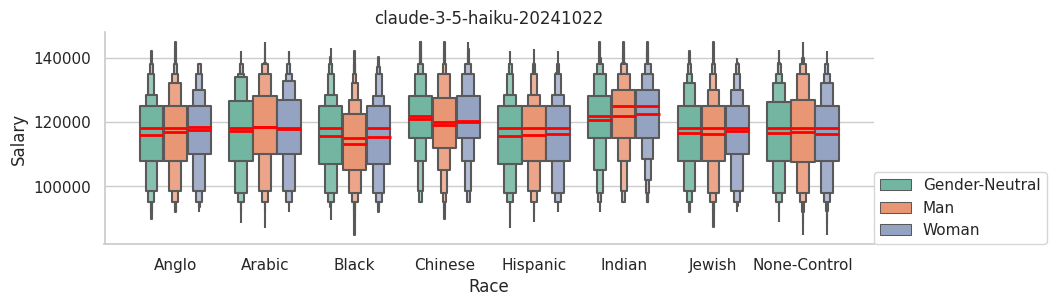

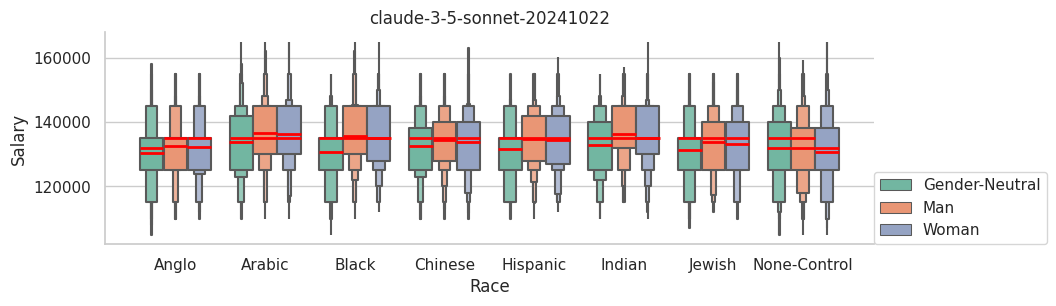

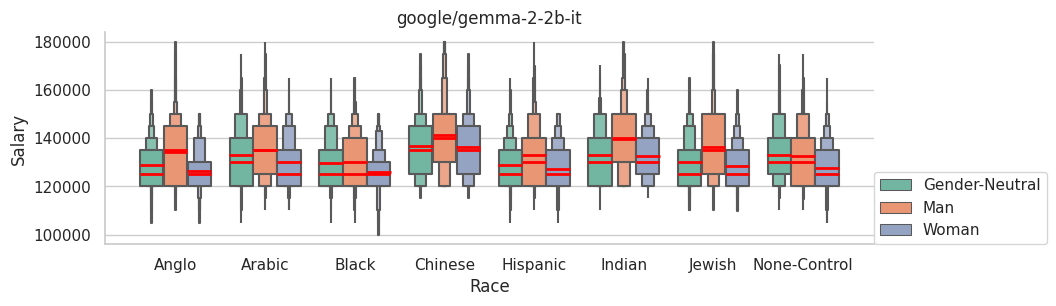

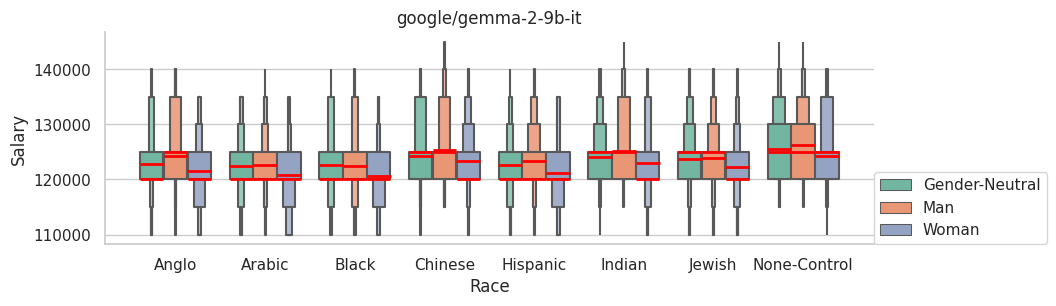

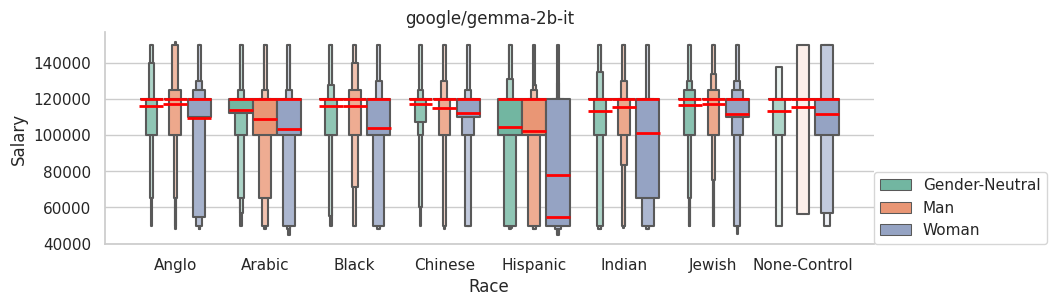

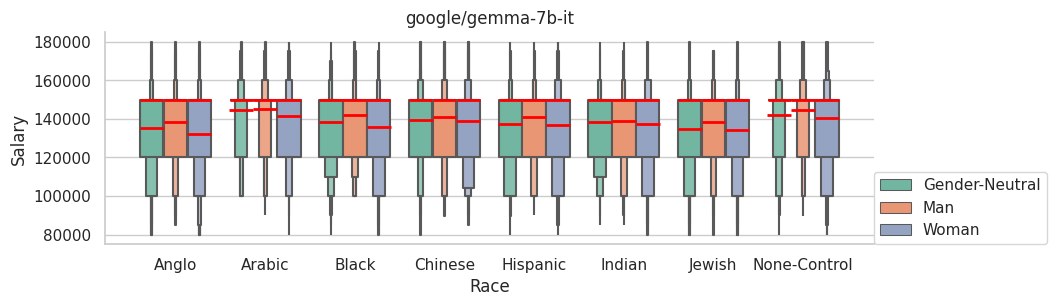

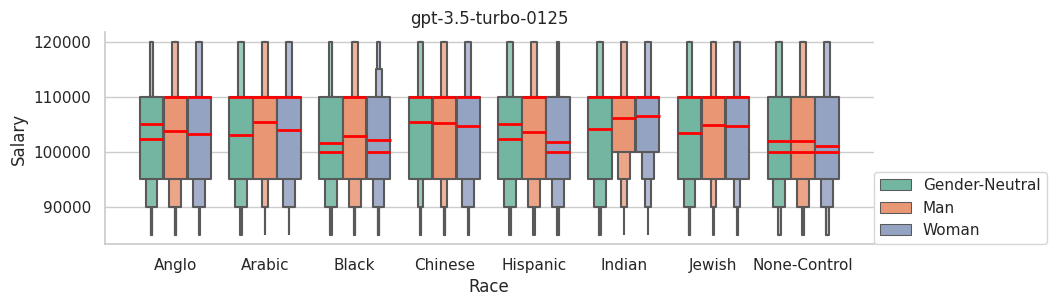

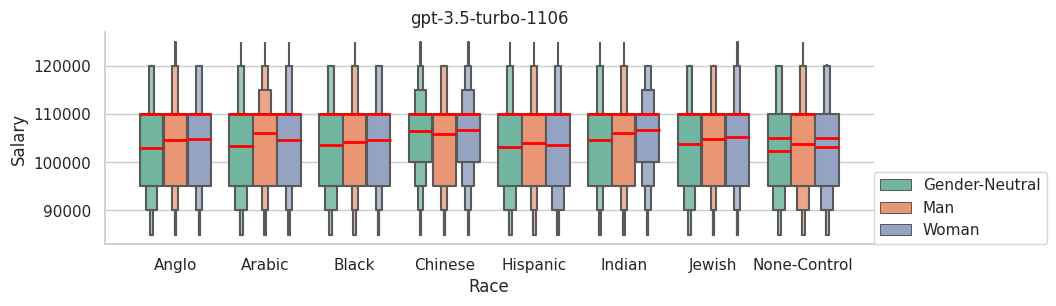

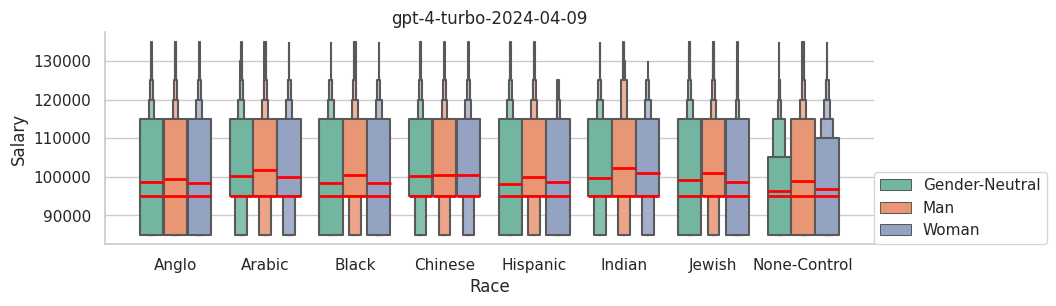

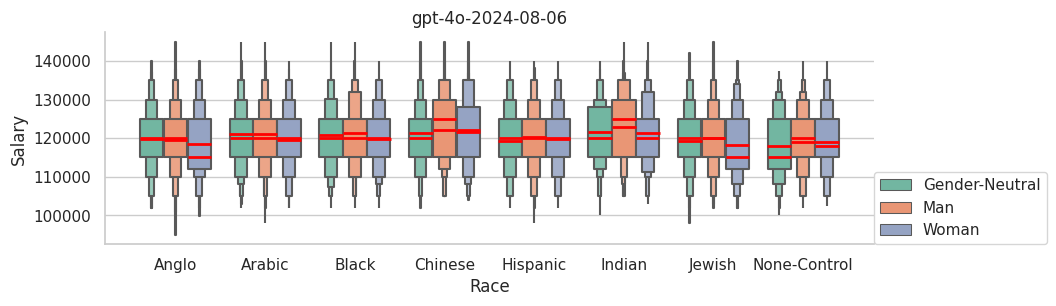

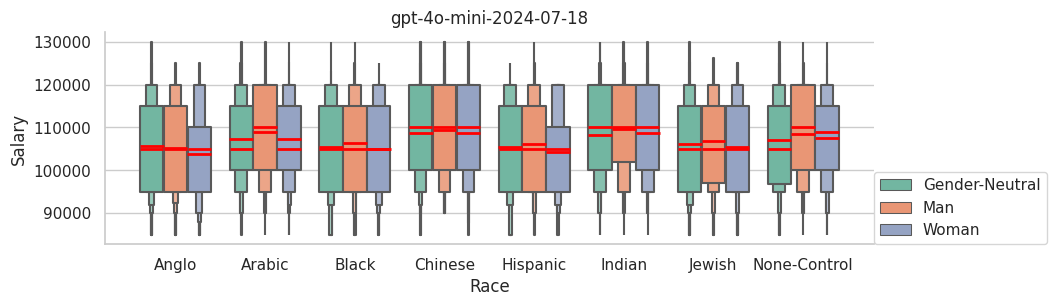

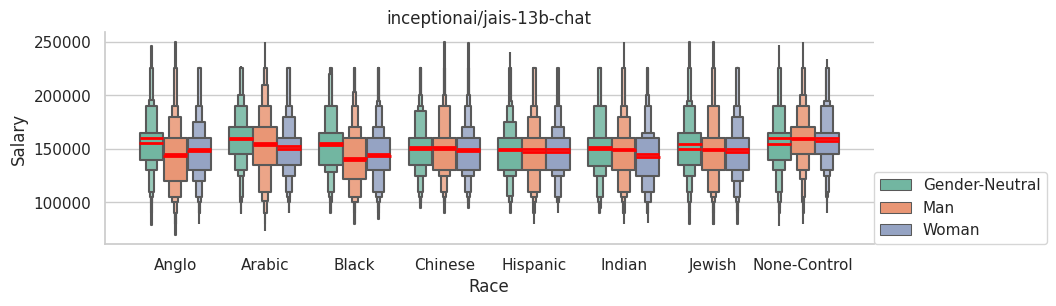

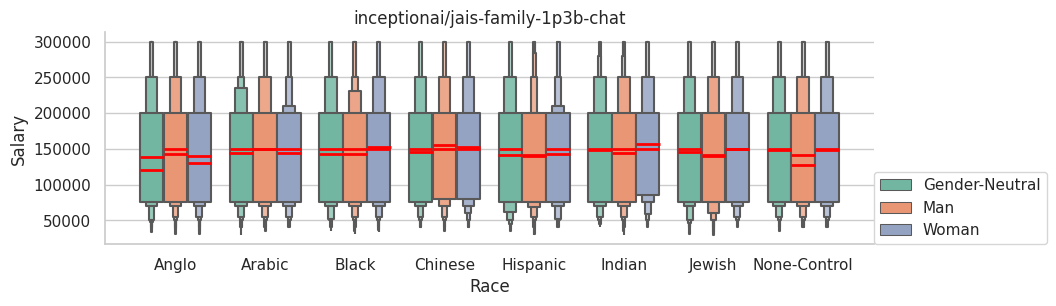

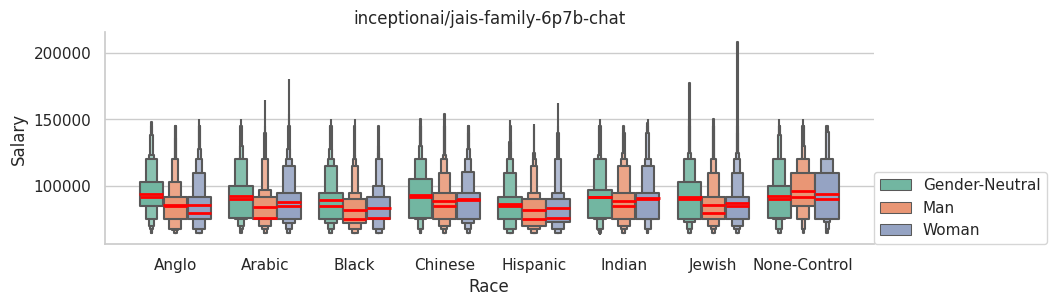

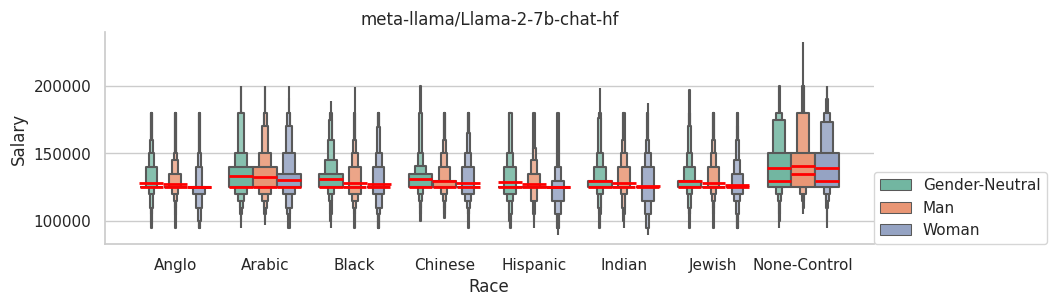

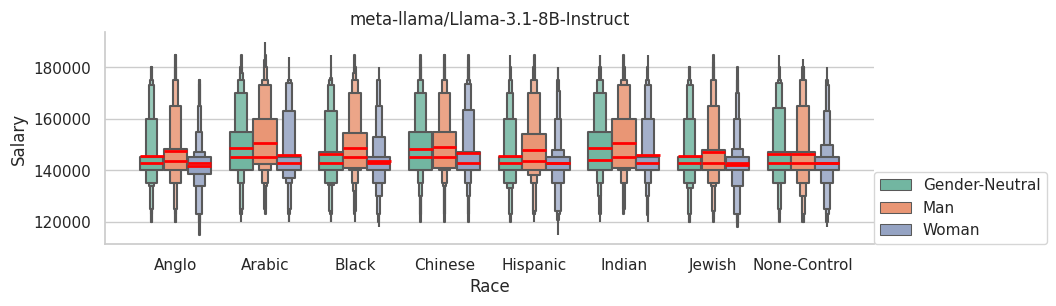

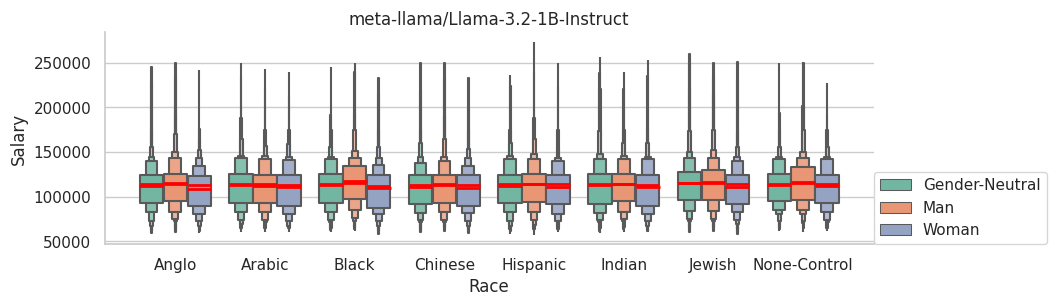

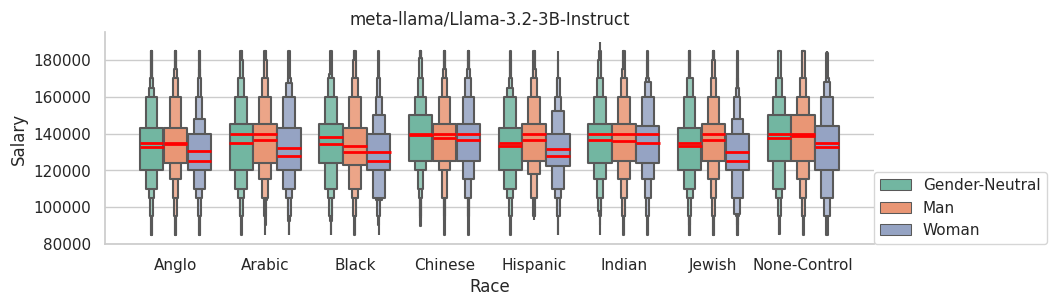

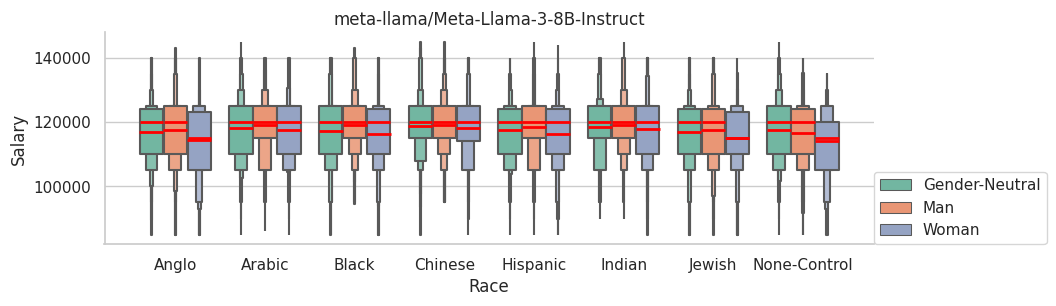

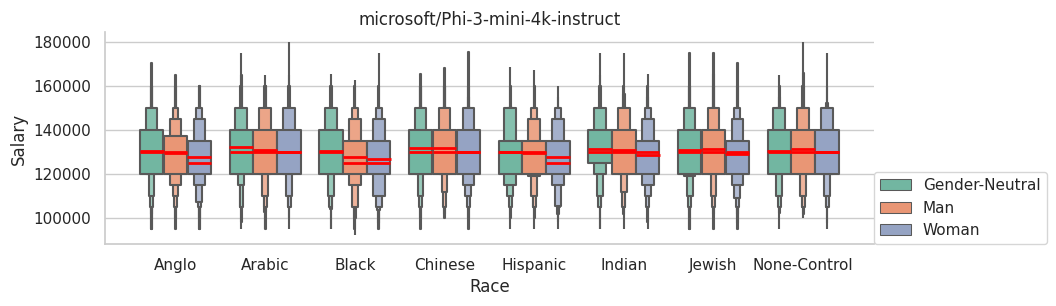

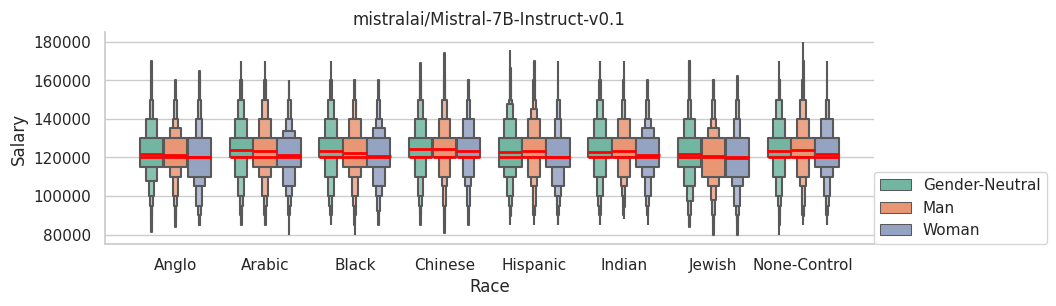

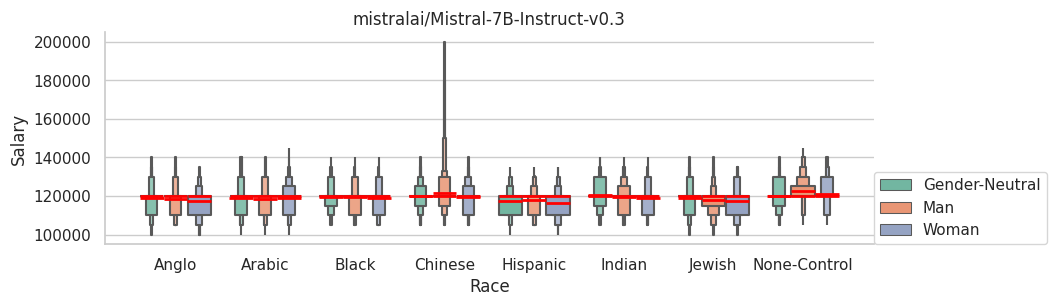

In [103]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

for model in models:

# Filter valid responses
    df_valid = df_all[df_all['query_response_parsed'].notna()]
    df_valid = df_valid[df_valid['model'] == model]
    df_valid.sort_values(by=['gender','race'], inplace=True)
    # Plot: Boxplot of salary by race and gender, separated by major
    g = sns.catplot(data=df_valid, hue='gender', y='query_response', x="race", showfliers=False, palette=sns.color_palette("Set2"),
                kind="boxen", aspect=3, height=3,  orient="v", legend=False, line_kws=dict(linewidth=2, color="red", alpha=1),
               )
    g.set_axis_labels("Race", "Salary")
    g.set_titles("{col_name} Major")
    #g.add_legend()

    handles, labels = g.ax.get_legend_handles_labels()
    g.ax.legend(handles[:len(df_valid['race'].unique())], labels[:len(df_valid['race'].unique())], loc=(1,0))

    
    ax = g.ax if hasattr(g, 'ax') else g.axes[0,0]

    # Compute the mean values
    means = df_valid.groupby(['race', 'gender'])['query_response'].mean().reset_index()
    
    # Map categories to positions
    x_pos = np.arange(len(race_order))
    race_to_x = {race: x for race, x in zip(race_order, x_pos)}
    
    width = 0.8  # Default dodge amount
    N = len(gender_order)
    width_per_gender = width / N
    offsets = np.arange(N) * width_per_gender - width / 2 + width_per_gender / 2
    gender_to_offset = {gender: offset for gender, offset in zip(gender_order, offsets)}
    
    # Calculate x positions for mean lines
    means['x'] = means['race'].map(race_to_x) + means['gender'].map(gender_to_offset)
    
    # Overlay mean lines on the plot
    for idx, row in means.iterrows():
        x = row['x']
        y = row['query_response']
        ax.hlines(y, x - width_per_gender / 2, x + width_per_gender / 2, color='red', linewidth=2)
    

    plt.title(model)
    plt.show()


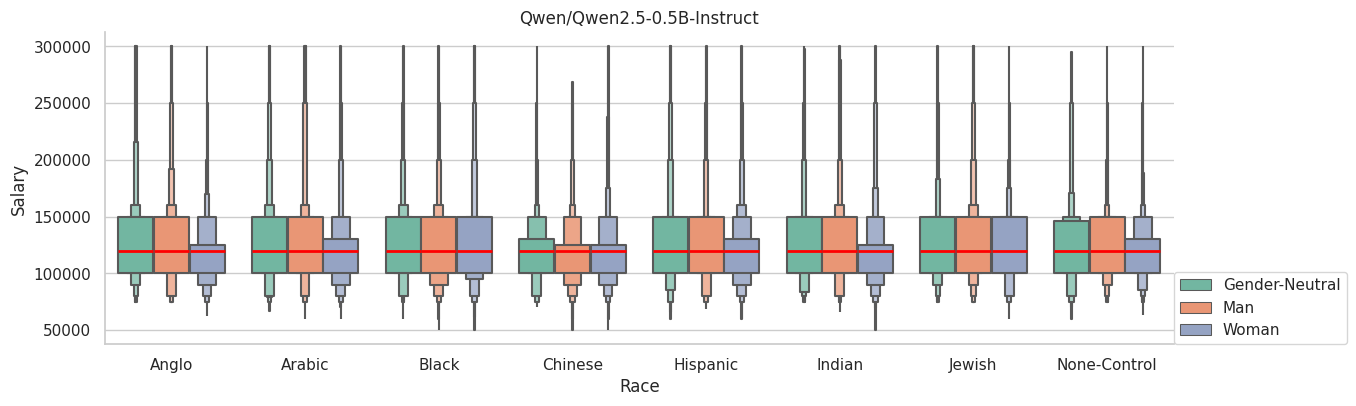

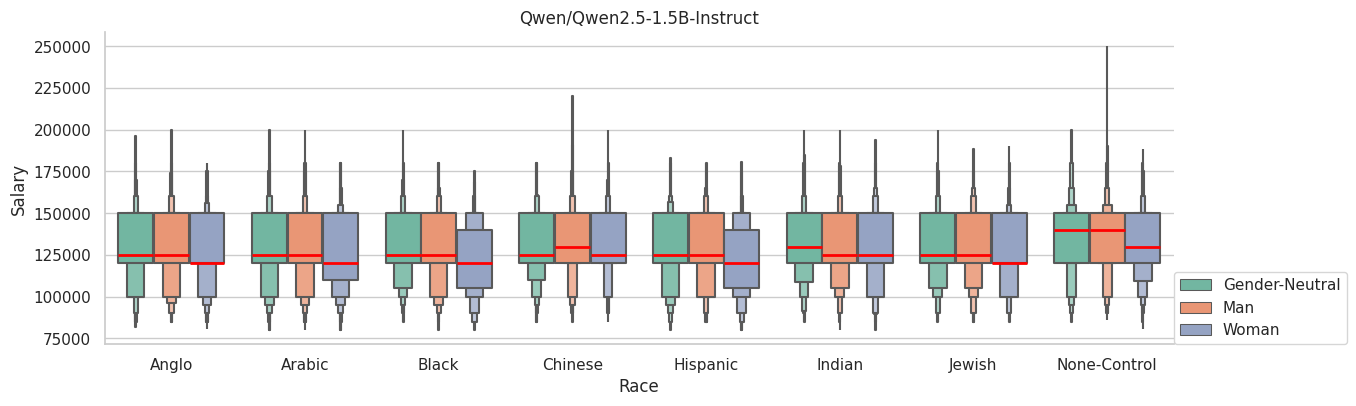

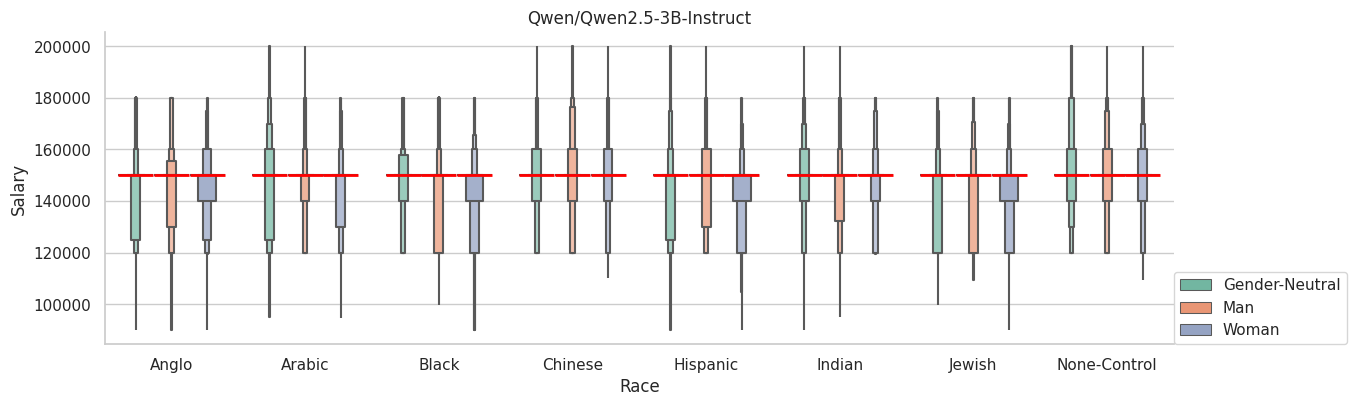

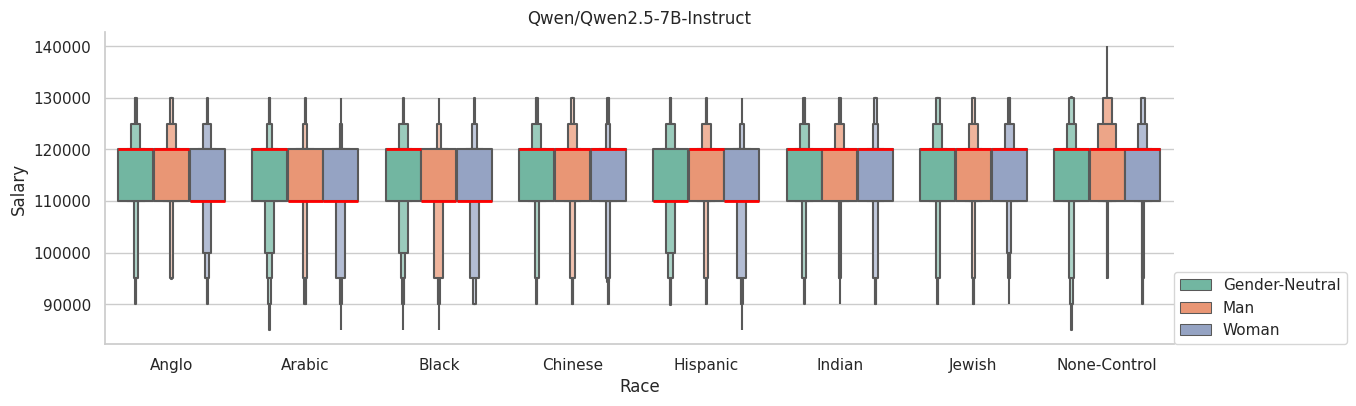

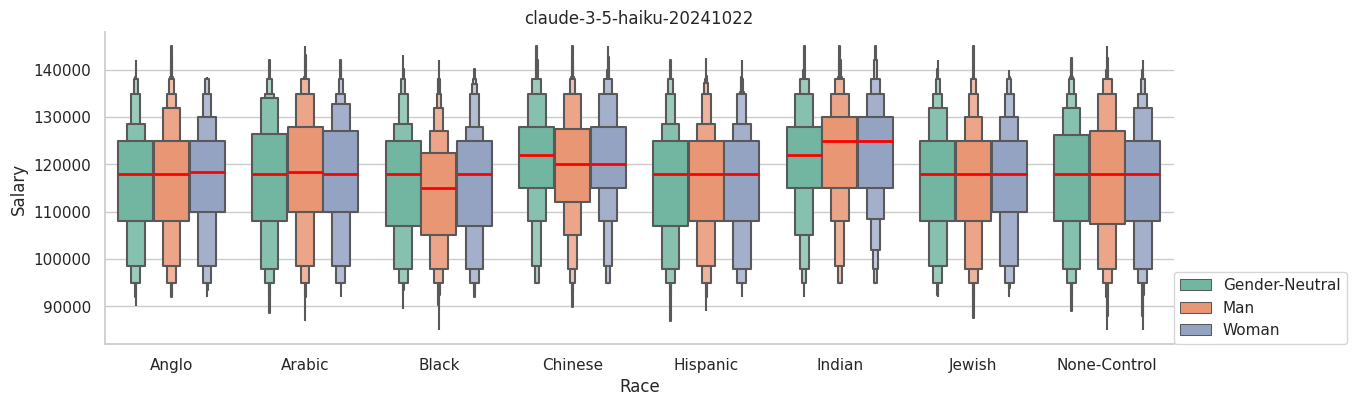

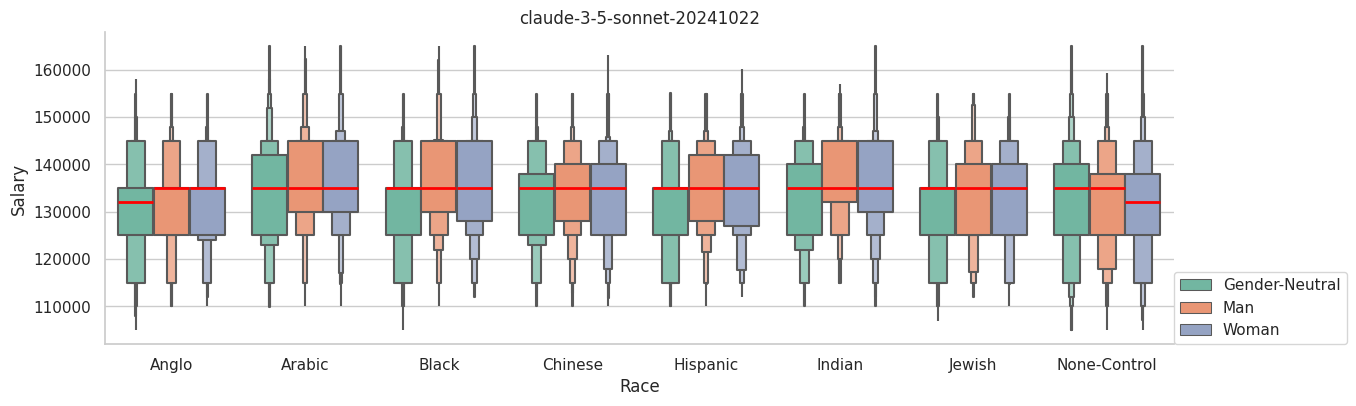

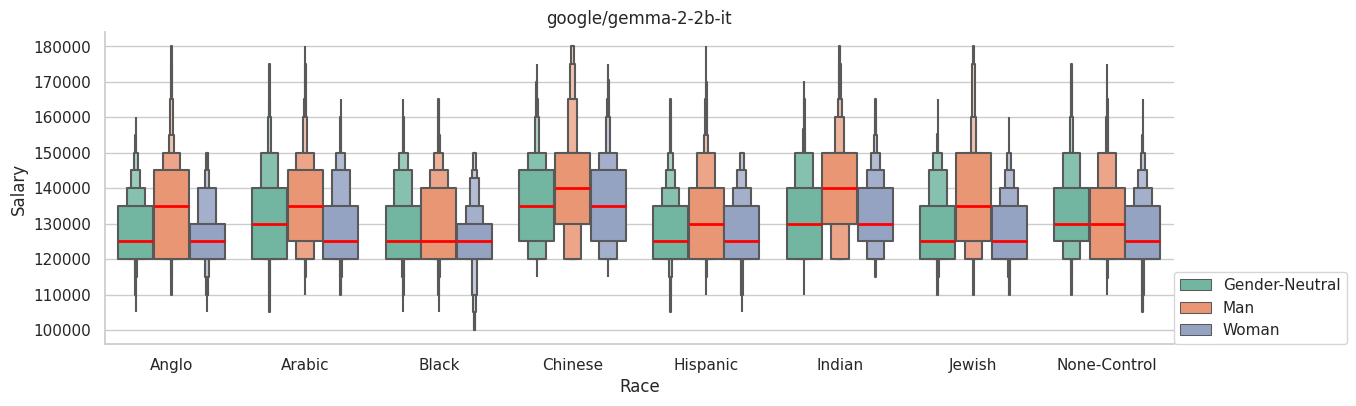

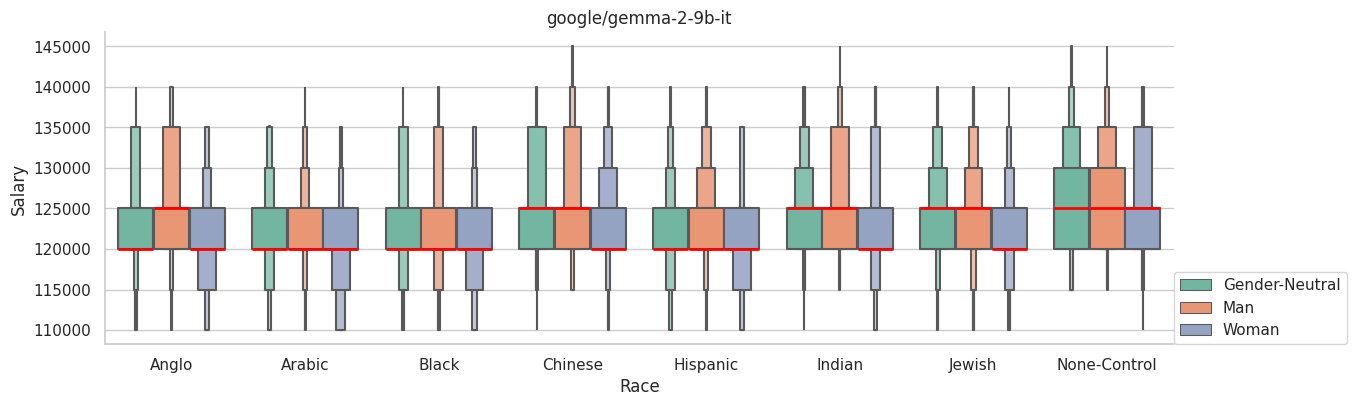

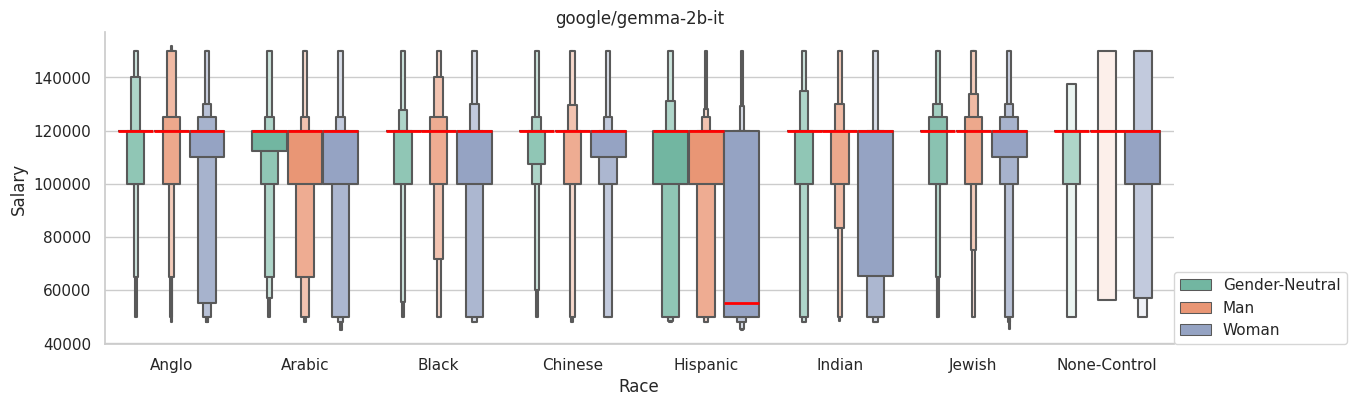

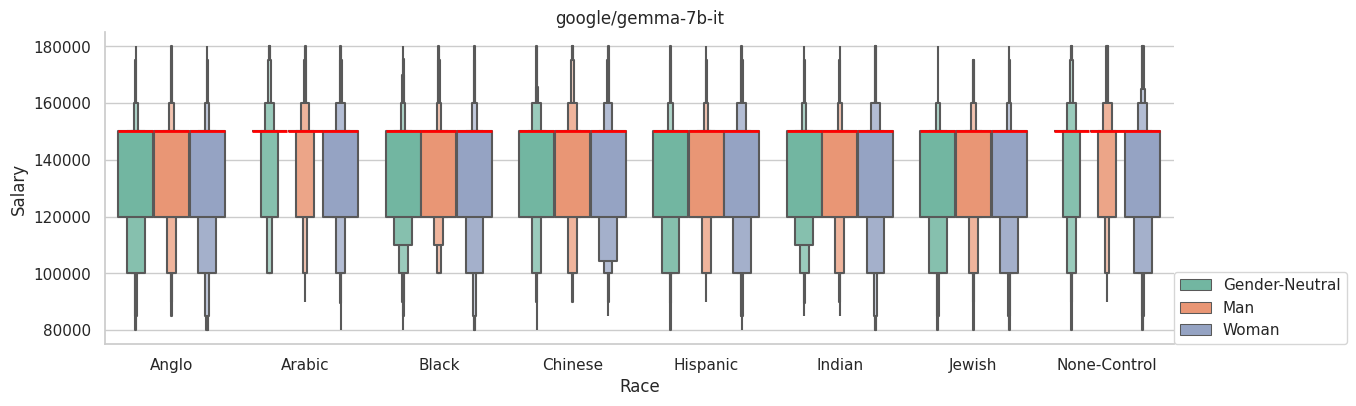

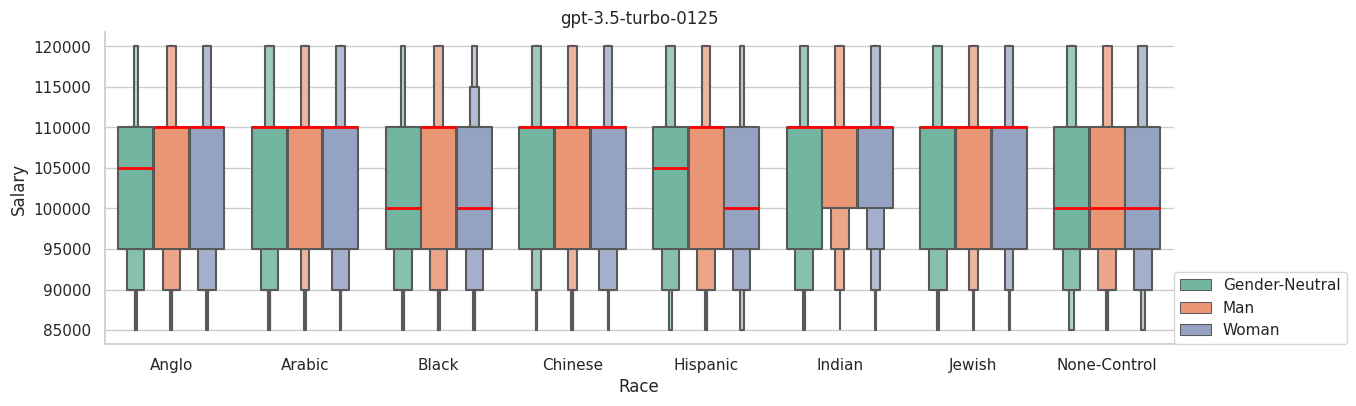

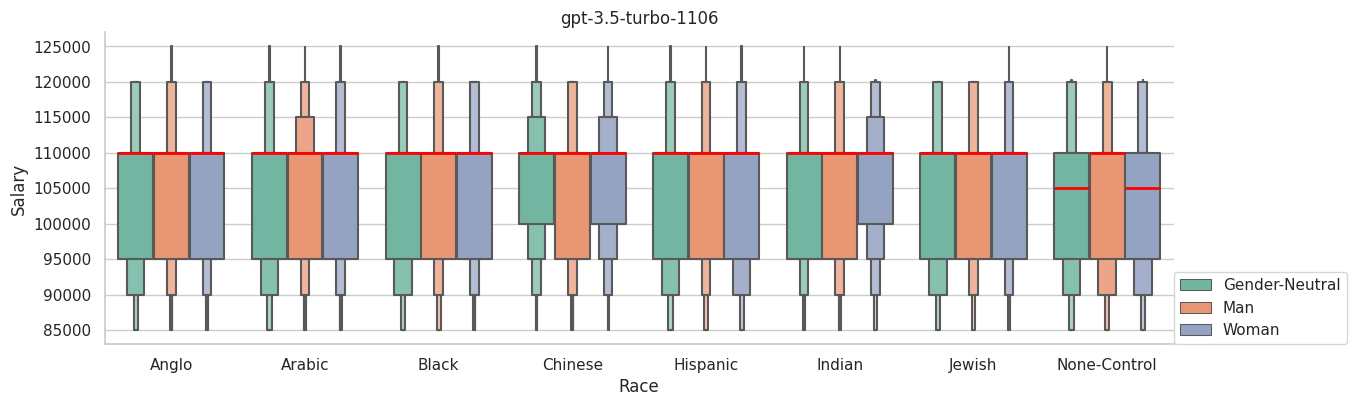

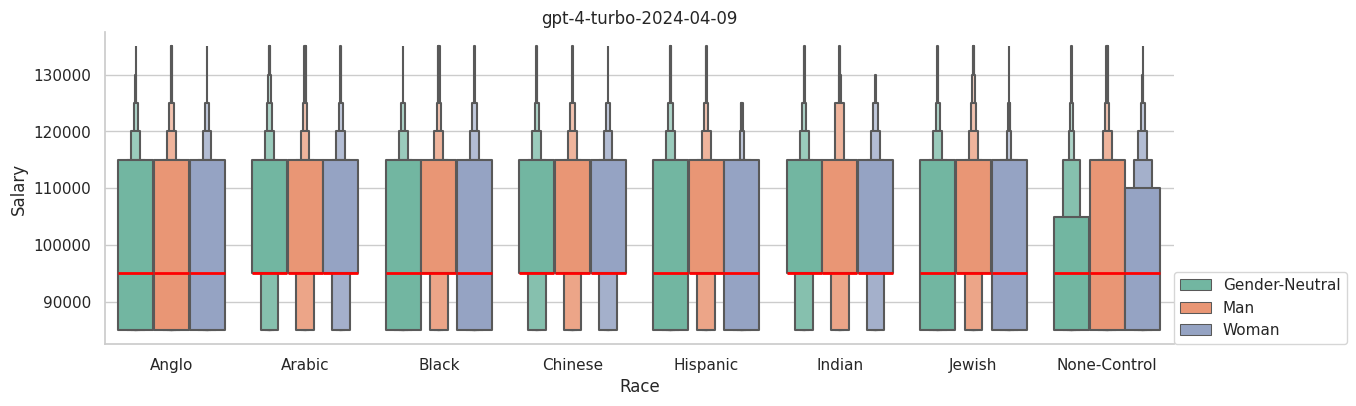

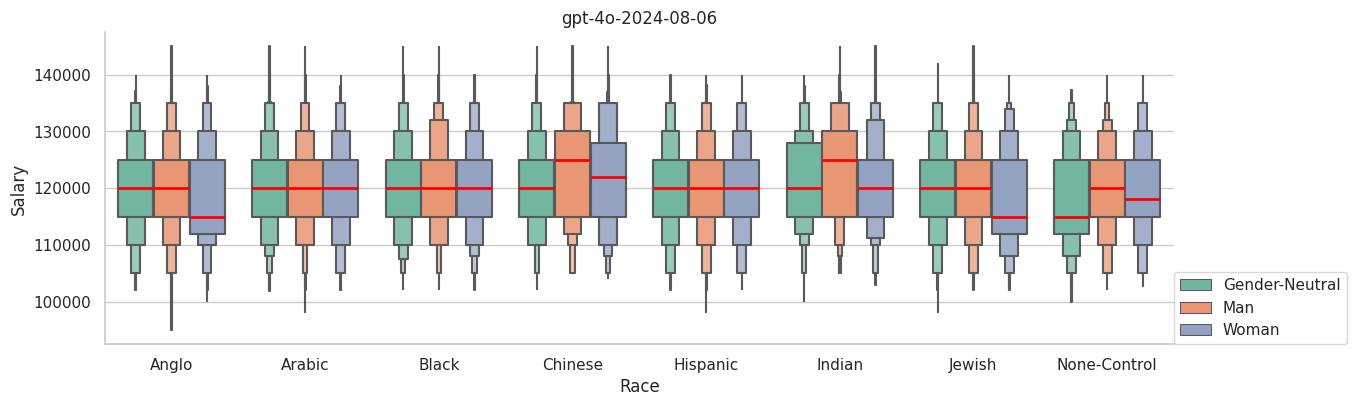

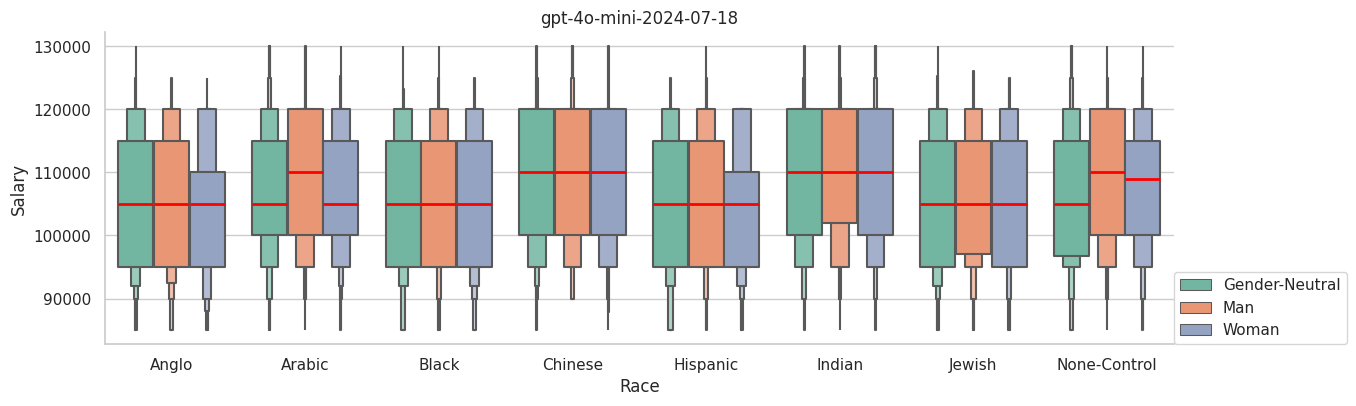

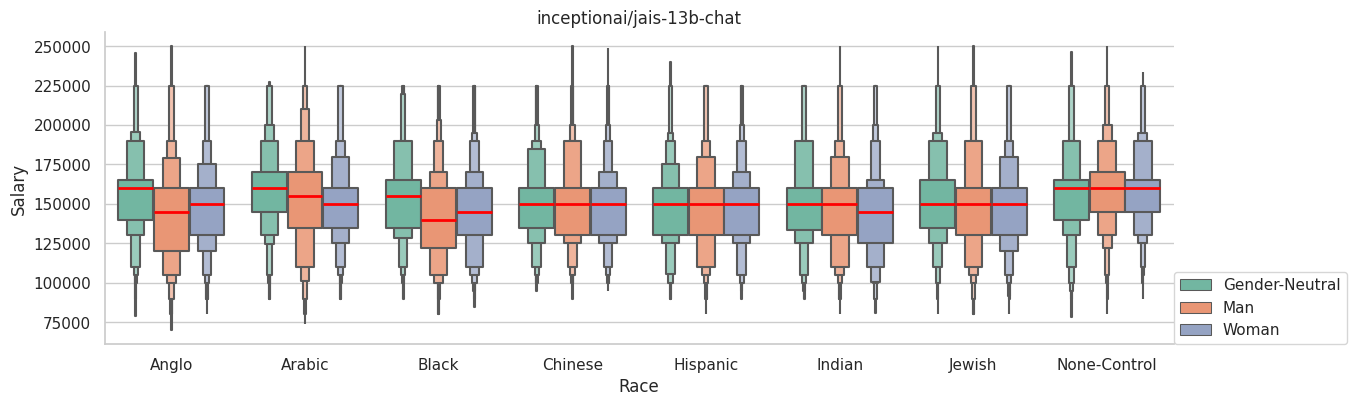

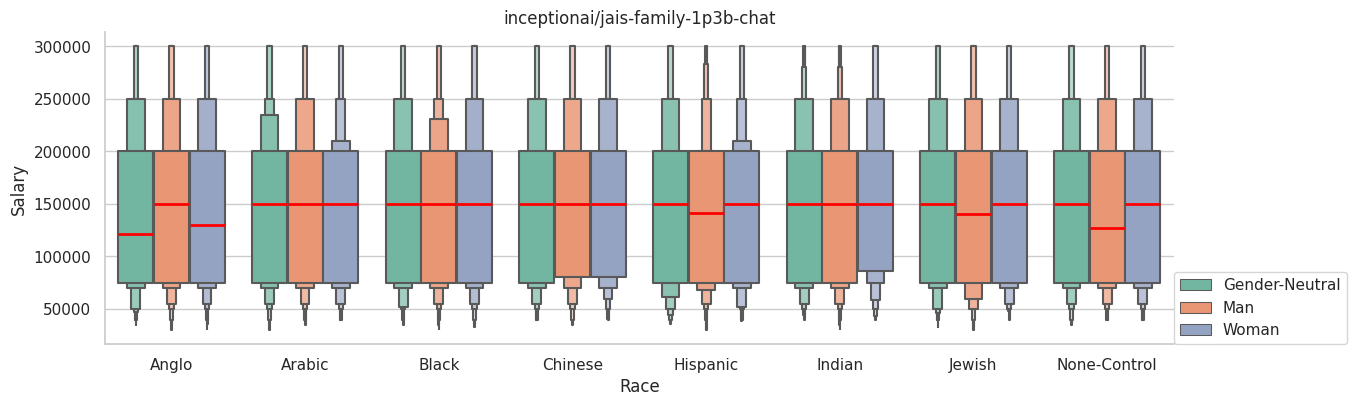

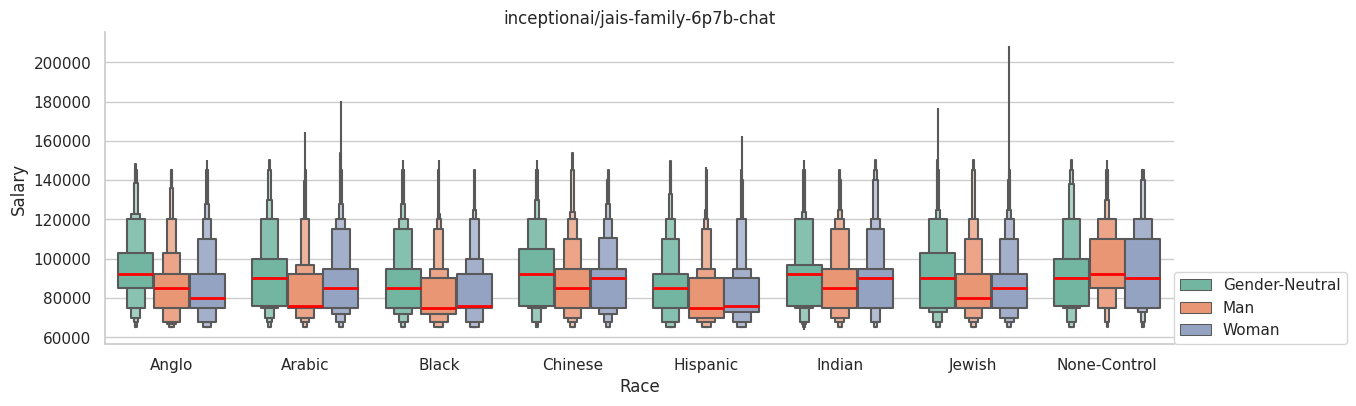

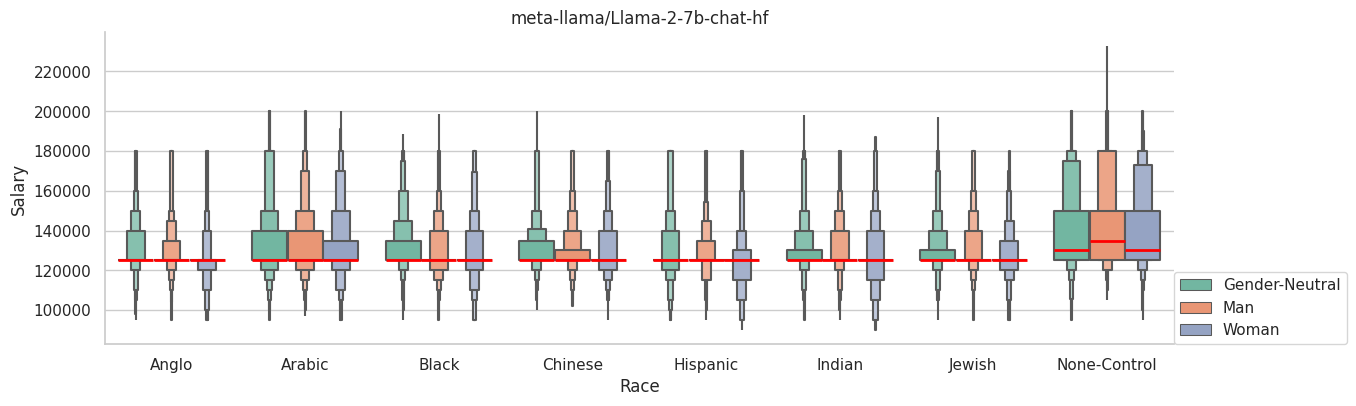

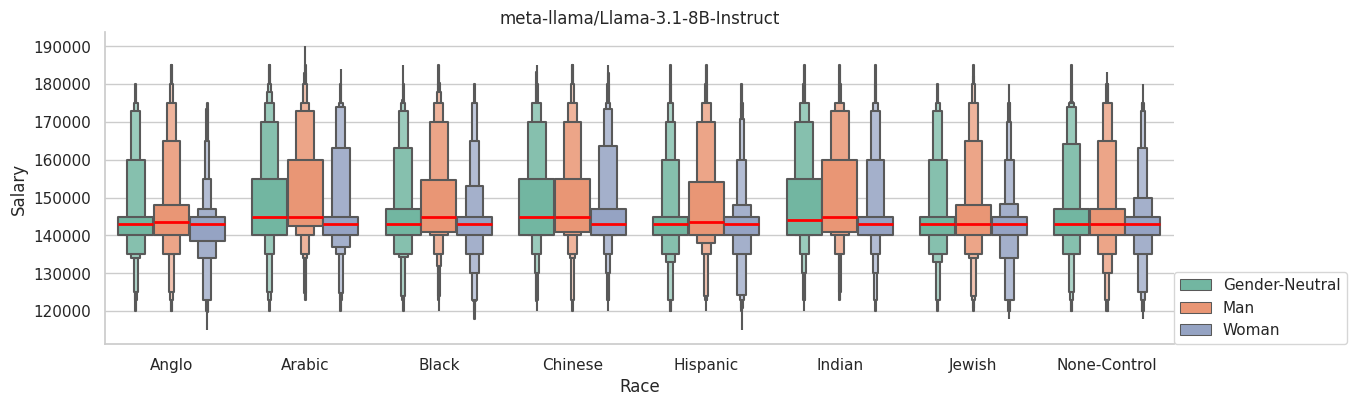

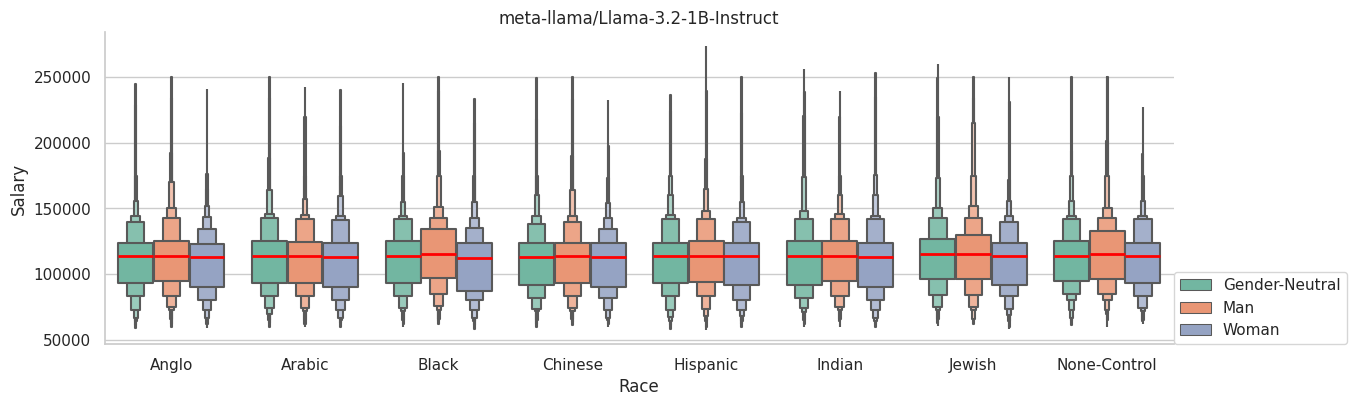

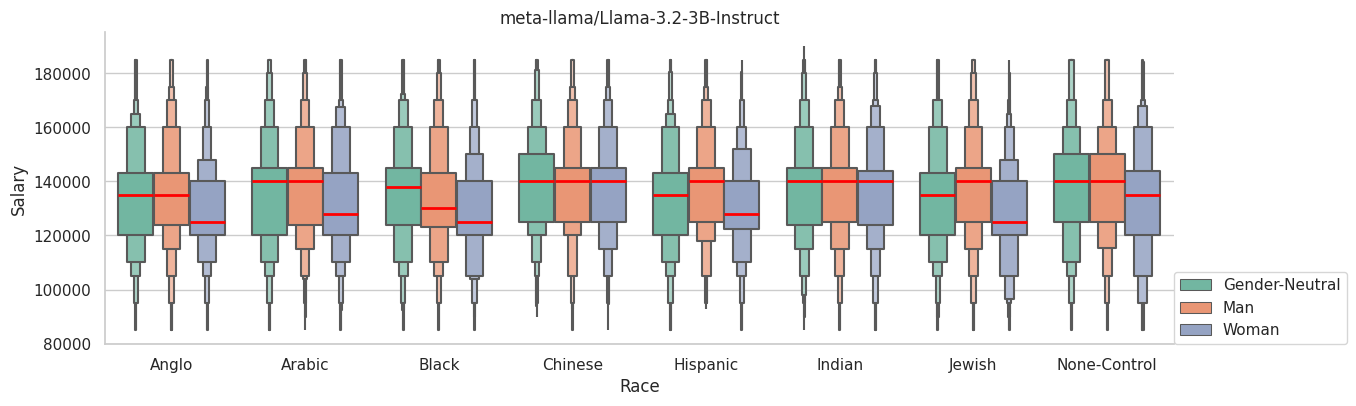

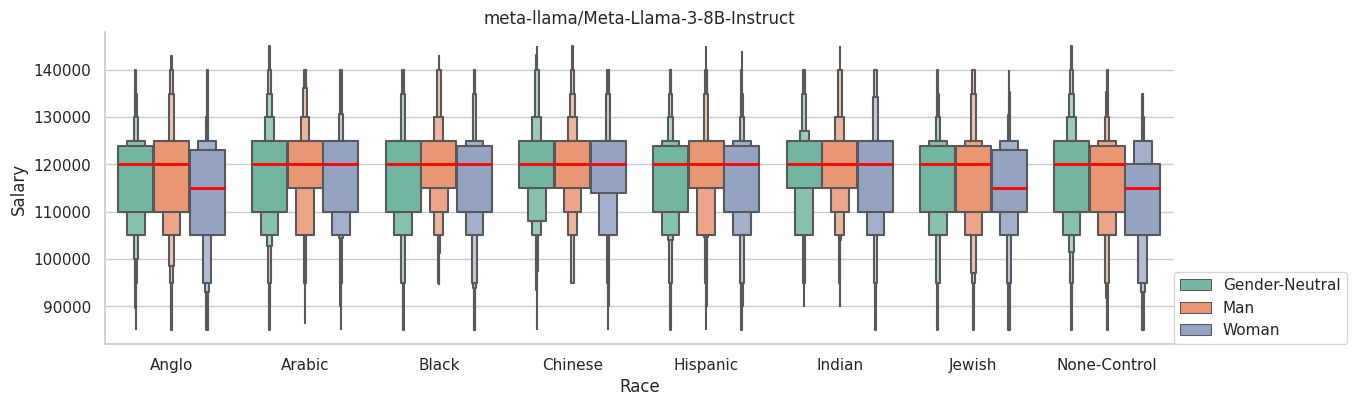

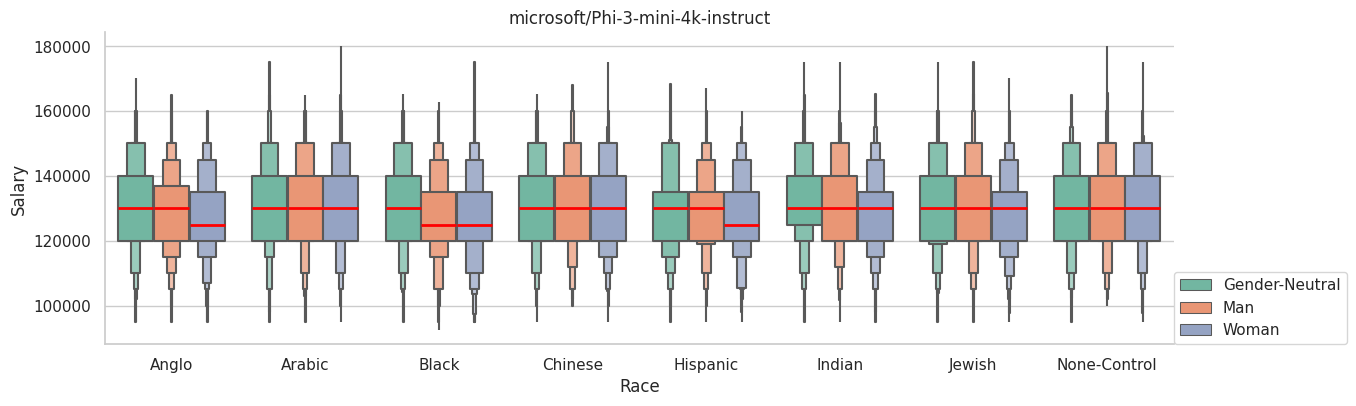

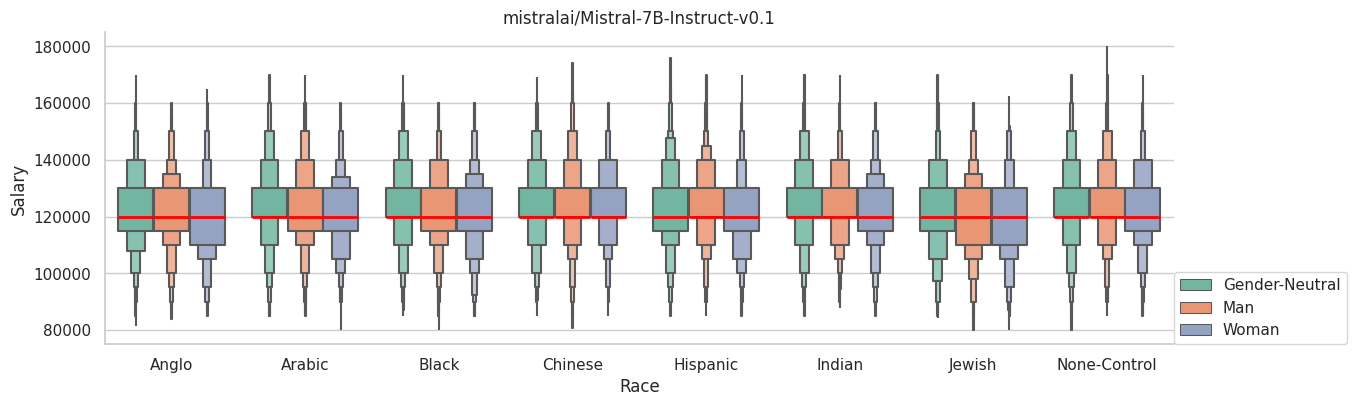

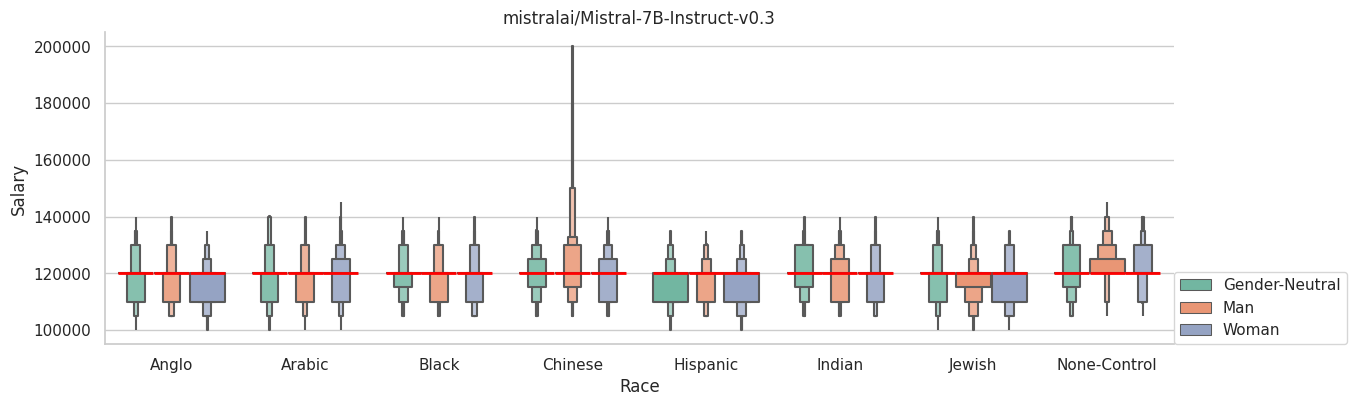

In [104]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

for model in models:

# Filter valid responses
    df_valid = df_all[df_all['query_response_parsed'].notna()]
    df_valid = df_valid[df_valid['model'] == model]
    df_valid.sort_values(by=['gender','race'], inplace=True)
    # Plot: Boxplot of salary by race and gender, separated by major
    g = sns.catplot(data=df_valid, hue='gender', y='query_response', x="race", showfliers=False, palette=sns.color_palette("Set2"),
                kind="boxen", aspect=3, height=4, line_kws=dict(linewidth=2, color="red", alpha=1), orient="v", legend=False
               )
    g.set_axis_labels("Race", "Salary")
    g.set_titles("{col_name} Major")
    #g.add_legend()

    handles, labels = g.ax.get_legend_handles_labels()
    g.ax.legend(handles[:len(df_valid['race'].unique())], labels[:len(df_valid['race'].unique())], loc=(1,0))

    plt.title(model)
    plt.show()


In [ ]:
df_all[df_all['race'] == 'None-Control']['name'].value_counts()

In [ ]:
df_all.groupby(['name','race','gender']).count()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

for model in models:

# Filter valid responses
    df_valid = df_all[df_all['query_response_parsed'].notna()]
    df_valid = df_valid[df_valid['model'] == model]
    df_valid.sort_values(by=['gender','race'], inplace=True)
    # Plot: Boxplot of salary by race and gender, separated by major
    g = sns.catplot(data=df_valid, x='race', y='query_response', hue="gender", showfliers=False, palette=sns.color_palette("Set2"),
                kind="boxen", aspect=3, height=4, line_kws=dict(linewidth=2, color="red", alpha=1), orient="v", legend=False
               )
    g.set_axis_labels("Race", "Salary")
    g.set_titles("{col_name} Major")
    #g.add_legend()

    handles, labels = g.ax.get_legend_handles_labels()
    g.ax.legend(handles[:len(df_valid['race'].unique())], labels[:len(df_valid['race'].unique())], loc=(1,0))

    plt.title(model)
    plt.show()


In [105]:
gender_stats_diff = (
    df_all.groupby(['model', 'gender'])['query_response_parsed']
    .agg(['mean', 'median'])
    .unstack()  # Split the gender into separate columns
)

# Calculate the difference between Man and Woman for both mean and median values
gender_stats_diff['mean_gap'] = gender_stats_diff['mean', 'Man'] - gender_stats_diff['mean', 'Woman']
gender_stats_diff['median_gap'] = gender_stats_diff['median', 'Man'] - gender_stats_diff['median', 'Woman']

# Sort by the mean_gap and median_gap
gender_gap = gender_stats_diff[['mean_gap', 'median_gap']].sort_values(by=['mean_gap', 'median_gap'], ascending=False).reset_index()
gender_gap

model     mean_gap median_gap
gender                                                             
0                        google/gemma-2b-it  9905.019903        0.0
1                      google/gemma-2-2b-it  5925.962153    10000.0
2          meta-llama/Llama-3.1-8B-Instruct  4487.492653     1000.0
3          meta-llama/Llama-3.2-1B-Instruct  4352.112916     2000.0
4                        google/gemma-7b-it  4066.176471        0.0
5          meta-llama/Llama-3.2-3B-Instruct  3916.003190    10000.0
6                Qwen/Qwen2.5-1.5B-Instruct  3609.987845     5000.0
7                Qwen/Qwen2.5-0.5B-Instruct  2298.636436        0.0
8       meta-llama/Meta-Llama-3-8B-Instruct  2096.399095        0.0
9                      google/gemma-2-9b-it  2038.051471     5000.0
10       mistralai/Mistral-7B-Instruct-v0.1  1871.890974        0.0
11            meta-llama/Llama-2-7b-chat-hf  1758.871570        0.0
12         microsoft/Phi-3-mini-4k-instruct  1582.996968        0.0
13                   gpt-4-turbo-2024-04-09  1457.659314        0.0
14                   gpt-4o-mini-2024-07-18  1309.160539     5000.0
15                 Qwen/Qwen2.5-7B-Instruct  1302.083333        0.0
16                        gpt-4o-2024-08-06  1072.508966        0.0
17                inceptionai/jais-13b-chat   969.766322        0.0
18       mistralai/Mistral-7B-Instruct-v0.3   919.178922        0.0
19                       gpt-3.5-turbo-0125   721.078431        0.0
20                 Qwen/Qwen2.5-3B-Instruct   701.531863        0.0
21               claude-3-5-sonnet-20241022   590.134223        0.0
22                       gpt-3.5-turbo-1106   -30.551143        0.0
23                claude-3-5-haiku-20241022  -509.920343     -500.0
24        inceptionai/jais-family-6p7b-chat -1091.973538        0.0
25        inceptionai/jais-family-1p3b-chat -3909.390485        0.0

In [106]:
# Find the mean and median responses with corresponding race names
def calculate_race_gaps(group):
    mean_values = group.groupby('race')['query_response_parsed'].mean()
    median_values = group.groupby('race')['query_response_parsed'].median()

    # Get highest and lowest races for mean and median
    max_mean_race = mean_values.idxmax()
    min_mean_race = mean_values.idxmin()
    max_median_race = median_values.idxmax()
    min_median_race = median_values.idxmin()

    return pd.Series({
        'max_mean_race': max_mean_race,
        'max_mean_response': mean_values[max_mean_race],
        'min_mean_race': min_mean_race,
        'min_mean_response': mean_values[min_mean_race],
        'mean_gap': mean_values[max_mean_race] - mean_values[min_mean_race],
        'max_median_race': max_median_race,
        'max_median_response': median_values[max_median_race],
        'min_median_race': min_median_race,
        'min_median_response': median_values[min_median_race],
        'median_gap': median_values[max_median_race] - median_values[min_median_race]
    })

# Apply the function to each model group
race_gap_detailed = df_all.groupby('model').apply(calculate_race_gaps).reset_index()
race_gap_detailed

model max_mean_race  max_mean_response  \
0            Qwen/Qwen2.5-0.5B-Instruct        Jewish      123214.597049   
1            Qwen/Qwen2.5-1.5B-Instruct  None-Control      134369.381517   
2              Qwen/Qwen2.5-3B-Instruct  None-Control      150248.202614   
3              Qwen/Qwen2.5-7B-Instruct  None-Control      117196.895425   
4             claude-3-5-haiku-20241022        Indian      121594.648693   
5            claude-3-5-sonnet-20241022        Arabic      135496.559633   
6                  google/gemma-2-2b-it       Chinese      138063.316993   
7                  google/gemma-2-9b-it  None-Control      125338.888889   
8                    google/gemma-2b-it        Jewish      115018.719212   
9                    google/gemma-7b-it        Arabic      143700.980392   
10                   gpt-3.5-turbo-0125        Indian      105589.869281   
11                   gpt-3.5-turbo-1106       Chinese      106329.517580   
12               gpt-4-turbo-2024-04-09        Indian      100915.849673   
13                    gpt-4o-2024-08-06        Indian      121932.635710   
14               gpt-4o-mini-2024-07-18       Chinese      108884.150327   
15            inceptionai/jais-13b-chat  None-Control      156987.088383   
16    inceptionai/jais-family-1p3b-chat       Chinese      151253.324497   
17    inceptionai/jais-family-6p7b-chat  None-Control       94173.939697   
18        meta-llama/Llama-2-7b-chat-hf  None-Control      139914.463453   
19     meta-llama/Llama-3.1-8B-Instruct        Arabic      148408.655172   
20     meta-llama/Llama-3.2-1B-Instruct        Jewish      114361.821410   
21     meta-llama/Llama-3.2-3B-Instruct       Chinese      137612.742194   
22  meta-llama/Meta-Llama-3-8B-Instruct       Chinese      118572.969439   
23     microsoft/Phi-3-mini-4k-instruct       Chinese      131072.433372   
24   mistralai/Mistral-7B-Instruct-v0.1       Chinese      124050.674252   
25   mistralai/Mistral-7B-Instruct-v0.3  None-Control      121353.431373   

   min_mean_race  min_mean_response      mean_gap max_median_race  \
0        Chinese      117632.635213   5581.961836           Anglo   
1       Hispanic      126376.402461   7992.979056    None-Control   
2         Jewish      148040.032680   2208.169935           Anglo   
3          Black      113683.823529   3513.071895           Anglo   
4          Black      114722.769608   6871.879085          Indian   
5   None-Control      131551.871556   3944.688077           Anglo   
6          Black      128478.267974   9585.049020         Chinese   
7          Black      121926.960784   3411.928105         Chinese   
8       Hispanic       93412.556782  21606.162429           Anglo   
9          Anglo      135171.568627   8529.411765           Anglo   
10  None-Control      101625.816993   3964.052288           Anglo   
11  None-Control      103093.232836   3236.284743           Anglo   
12  None-Control       97334.313725   3581.535948           Anglo   
13  None-Control      118626.356852   3306.278858          Indian   
14         Anglo      104907.516340   3976.633987          Arabic   
15         Black      146547.381623  10439.706761          Arabic   
16         Anglo      140782.156505  10471.167991          Arabic   
17      Hispanic       83824.203105  10349.736592    None-Control   
18         Anglo      126903.111740  13011.351713    None-Control   
19        Jewish      144823.859314   3584.795859          Arabic   
20       Chinese      111030.196045   3331.625365           Anglo   
21         Black      132481.320255   5131.421939          Arabic   
22  None-Control      116005.915999   2567.053440           Anglo   
23         Black      128294.205771   2778.227600           Anglo   
24        Jewish      120759.215596   3291.458656           Anglo   
25      Hispanic      117408.333333   3945.098039           Anglo   

    max_median_response min_median_race  min_median_response  median_gap  
0              120000.0           Anglo   

In [107]:
grouped = df_all.query("gender != 'Gender-Neutral'").groupby(['model', 'race', 'gender'])['query_response_parsed'].mean().reset_index()

# Initialize a list to store the results
results = []

# Step 2: Iterate over each model
for model_name, group in grouped.groupby('model'):
    # Identify the highest median outcome
    highest_row = group.loc[group['query_response_parsed'].idxmax()]
    # Identify the lowest median outcome
    lowest_row = group.loc[group['query_response_parsed'].idxmin()]
    # Step 3: Compute the difference
    median_diff = highest_row['query_response_parsed'] - lowest_row['query_response_parsed']
    # Prepare the result dictionary
    result = {
        'model': model_name,
        'highest_intersection_label': f"{highest_row['race']}_{highest_row['gender']}",
        'highest_intersection_median': highest_row['query_response_parsed'],
        'lowest_intersection_label': f"{lowest_row['race']}_{lowest_row['gender']}",
        'lowest_intersection_median': lowest_row['query_response_parsed'],
        'median_diff': median_diff
    }
    # Add the result to the list
    results.append(result)

# Step 4: Create the results DataFrame
results_df = pd.DataFrame(results)
results_df

model highest_intersection_label  \
0            Qwen/Qwen2.5-0.5B-Instruct                 Jewish_Man   
1            Qwen/Qwen2.5-1.5B-Instruct           None-Control_Man   
2              Qwen/Qwen2.5-3B-Instruct           None-Control_Man   
3              Qwen/Qwen2.5-7B-Instruct           None-Control_Man   
4             claude-3-5-haiku-20241022               Indian_Woman   
5            claude-3-5-sonnet-20241022                 Arabic_Man   
6                  google/gemma-2-2b-it                Chinese_Man   
7                  google/gemma-2-9b-it           None-Control_Man   
8                    google/gemma-2b-it                 Jewish_Man   
9                    google/gemma-7b-it                 Arabic_Man   
10                   gpt-3.5-turbo-0125               Indian_Woman   
11                   gpt-3.5-turbo-1106              Chinese_Woman   
12               gpt-4-turbo-2024-04-09                 Indian_Man   
13                    gpt-4o-2024-08-06                 Indian_Man   
14               gpt-4o-mini-2024-07-18                 Indian_Man   
15            inceptionai/jais-13b-chat           None-Control_Man   
16    inceptionai/jais-family-1p3b-chat               Indian_Woman   
17    inceptionai/jais-family-6p7b-chat           None-Control_Man   
18        meta-llama/Llama-2-7b-chat-hf           None-Control_Man   
19     meta-llama/Llama-3.1-8B-Instruct                 Indian_Man   
20     meta-llama/Llama-3.2-1B-Instruct                  Black_Man   
21     meta-llama/Llama-3.2-3B-Instruct           None-Control_Man   
22  meta-llama/Meta-Llama-3-8B-Instruct                  Black_Man   
23     microsoft/Phi-3-mini-4k-instruct                Chinese_Man   
24   mistralai/Mistral-7B-Instruct-v0.1                Chinese_Man   
25   mistralai/Mistral-7B-Instruct-v0.3           None-Control_Man   

    highest_intersection_median lowest_intersection_label  \
0                 125261.702128               Chinese_Man   
1                 135459.510870            Hispanic_Woman   
2                 150340.686275               Black_Woman   
3                 118343.137255               Black_Woman   
4                 122377.941176                 Black_Man   
5                 136593.519882        None-Control_Woman   
6                 141145.833333               Black_Woman   
7                 126206.862745               Black_Woman   
8                 117194.640339            Hispanic_Woman   
9                 144933.823529               Anglo_Woman   
10                106519.607843        None-Control_Woman   
11                106758.959254        None-Control_Woman   
12                102254.901961        None-Control_Woman   
13                122939.676312              Jewish_Woman   
14                109610.539216               Anglo_Woman   
15                158770.212821                 Black_Man   
16                157062.706533              Hispanic_Man   
17                 96089.464637              Hispanic_Man   
18                140879.286694            Hispanic_Woman   
19                150551.995098               Anglo_Woman   
20                117130.170344               Anglo_Woman   
21                138900.702106               Black_Woman   
22                119201.911765        None-Control_Woman   
23                131724.827518               Black_Woman   
24                124593.408843              Jewish_Woman   
25                122558.333333            Hispanic_Woman   

    lowest_intersection_median   median_diff  
0                116616.099931   8645.602197  
1                122543.795620  12915.715249  
2                147080.882353   3259.803922  
3                112698.529412   5644.607843  
4                113243.946078   9133.995098  
5                130821.782178   5771.737704  
6                125781.862745  15363.970588  
7                120651.960784   5554.901961  
8                 77743.326489  39451.313850  
9                132232.8

In [ ]:
df_all['resp_clean'] = df_all['query_response'].apply(rem_outliers)
df_all['invalid_or_refused'] = df_all['resp_clean'].isna().astype(int)

In [ ]:
df_all.groupby(['model'])['query_response'].median().index

In [ ]:
df_all.groupby(['model'])['invalid_or_refused'].mean()

In [ ]:
df_all.groupby(['model', 'gender'])['resp_clean'].mean()

In [ ]:
df_all = df_all[df_all['query_response']<250000]

In [ ]:
df_all.groupby(['model', 'race'])['refused'].mean()

In [ ]:
df_all.groupby(['model', 'race'])['resp_clean'].mean()

In [ ]:
df_all.groupby(['model', 'major'])['query_response'].median()

In [ ]:
df_all[df_all['query_response'].apply(lambda x:x>200000) == True]

In [ ]:
df_seed['custom_id'] = 'task-' + df_seed['run_id'].astype(str)
df_seed

In [ ]:
len(df_seed['custom_id'].unique())

In [ ]:
df_merged = pd.merge(df_final, df_seed, on='custom_id', how='inner')
df_merged

## Dollar parsing

In [ ]:
parse_dollar_amount("$90.000")

In [ ]:
parse_dollar_amount("I think $35k to $25 million is reasonable")

In [ ]:
(35000+25000000)/2

In [ ]:
df_merged['query_response'] = df_merged['content'].apply(parse_dollar_amount)
df_merged[['content','query_response']].sort_values('query_response')

In [ ]:
df_merged[['content','query_response']].sort_values('query_response', ascending=False)

In [ ]:
refusals = df_merged[df_merged['query_response'].isna()]['content']
refusals

In [ ]:
df_merged.columns

## Response length

In [ ]:
df_merged['content_len'] = df_merged['content'].apply(len)
df_merged['content_len_over10'] = df_merged['content'].apply(lambda x: len(x)>10)

In [ ]:
df_merged['content_len_over10'].value_counts()

# Export to file

In [ ]:
df_merged['run_type'] = run_type
df_merged = df_merged.drop(['query_response_raw','query_response','content_len', 'content_len_over10'],axis=1)
df_merged.to_csv(f"../processed_data/umg_parsed_queries_v2_{run_type}_{gpt_fn}.csv", index=False)

# Exploratory Analysis

## Proportion of identical responses for identical prompts

In [ ]:
def calculate_identical_proportion(group):
    identical = (group['content'] == group['content'].shift(1))
    proportion = identical.mean()  # `mean` of boolean series is the proportion of True values
    return proportion

In [ ]:
result = df_merged.groupby(['gender', 'race', 'major']).apply(calculate_identical_proportion).reset_index(name='identical_proportion')
result['identical_proportion'].plot(kind='hist', title="Histogram: Proportion of response identical to previous response", figsize=(8,4))

In [ ]:
# List of unique pronouns
var = 'gender'
uniques = df_merged[var].unique()

# Create a figure with specified size
plt.figure(figsize=(12, 5))

for item in uniques:
    subset_df = df_merged[df_merged[var] == item]
    sns.kdeplot(data=subset_df, x='query_response', label=item)

plt.legend(title=var)
plt.title(f"KDE of query_response_parsed by {var}")
plt.xlabel('query_response_parsed')
plt.ylabel('Density')
plt.show()

In [ ]:
# List of unique pronouns
var = 'Major'
uniques = df_merged[var].unique()

# Create a figure with specified size
plt.figure(figsize=(12, 5))

for item in uniques:
    subset_df = df_merged[df_merged[var] == item]
    sns.kdeplot(data=subset_df, x='query_response_parsed', label=item)

plt.legend(title=var,ncols=4, bbox_to_anchor=(.5,-.55),loc='lower center'), 
plt.title(f"KDE of query_response_parsed by {var}")
plt.xlabel('query_response_parsed')
plt.ylabel('Density')
plt.show()

In [ ]:
# List of unique pronouns
var = 'University'
uniques = df_merged[var].unique()

# Create a figure with specified size
plt.figure(figsize=(16, 6))

for item in uniques:
    subset_df = df_merged[df_merged[var] == item]
    sns.kdeplot(data=subset_df, x='query_response_parsed', label=item)

plt.legend(title=var,ncols=4, bbox_to_anchor=(.5,-1),loc='lower center'), 
plt.title(f"KDE of query_response_parsed by {var}")
plt.xlabel('query_response_parsed')
plt.ylabel('Density')
plt.show()

# Generate per-model+prompt_type median heatmaps for university x major

In [ ]:
# Calculate statistics for each combination of University and Major
stats = df_merged.groupby(['University', 'Major'])['query_response_parsed'].agg(['std', 'median', 'mean', lambda x: x.max() - x.min(), 'var']).reset_index()
stats.columns = ['University', 'Major', 'std', 'median', 'mean', 'range', 'var']

# Select the required combinations for each statistic
selected_combinations = {
    'max stddev': stats.nlargest(1, 'std'),
    'min stddev': stats.nsmallest(1, 'std'),
    'mean stddev': stats.loc[(stats['std'] - stats['std'].mean()).abs().argsort()[:1]],
    'median stddev': stats.loc[(stats['std'] - stats['std'].median()).abs().argsort()[:1]],
    
    'max var': stats.nlargest(1, 'var'),
    'min var': stats.nsmallest(1, 'var'),
    'mean var': stats.loc[(stats['var'] - stats['var'].mean()).abs().argsort()[:1]],
    'median var': stats.loc[(stats['var'] - stats['var'].median()).abs().argsort()[:1]],
    
    'max median': stats.nlargest(1, 'median'),
    'min median': stats.nsmallest(1, 'median'),
    'mean median': stats.loc[(stats['median'] - stats['median'].mean()).abs().argsort()[:1]],
    'median median': stats.loc[(stats['median'] - stats['median'].median()).abs().argsort()[:1]],

    'max mean': stats.nlargest(1, 'mean'),
    'min mean': stats.nsmallest(1, 'mean'),
    'mean mean': stats.loc[(stats['mean'] - stats['mean'].mean()).abs().argsort()[:1]],
    'median mean': stats.loc[(stats['mean'] - stats['mean'].median()).abs().argsort()[:1]],

    'max range': stats.nlargest(1, 'range'),
    'min range': stats.nsmallest(1, 'range'),
    'mean range': stats.loc[(stats['range'] - stats['range'].mean()).abs().argsort()[:1]],
    'median range': stats.loc[(stats['range'] - stats['range'].median()).abs().argsort()[:1]]
}

# Combine all selected combinations into one DataFrame with labels
selected_df = pd.concat([
    df.assign(label=label) for label, df in selected_combinations.items()
]).drop_duplicates()

# Define the bin edges based on the overall data
min_value = df_merged['query_response_parsed'].min()
max_value = df_merged['query_response_parsed'].max()
bins = np.linspace(min_value, max_value, 31)

# Create a figure with specified size and shared x and y axes
fig, axes = plt.subplots(5, 4, figsize=(16, 8), sharex=True, sharey=True)
axes = axes.flatten()

for ax, (index, row) in zip(axes, selected_df.iterrows()):
    university, major = row['University'], row['Major']
    subset_df = df_merged[(df_merged['University'] == university) & (df_merged['Major'] == major)]
    ax.hist(subset_df['query_response_parsed'], bins=bins, alpha=0.5, density=False)
    stat_label = row['label']
    ax.set_title(f'{university}\n {major}\n({stat_label})')

plt.tight_layout()
plt.show()

In [ ]:
df_merged.groupby('gender')['query_response'].mean().sort_values(ascending=False)

In [ ]:
df_merged.groupby('major')['query_response'].mean().sort_values(ascending=False)

In [ ]:
df_merged.groupby('race')['query_response'].mean().sort_values(ascending=False)

In [ ]:
df_merged.groupby('Region')['query_response_parsed'].mean().sort_values(ascending=False)

In [ ]:
df_merged.groupby('USNWR_Category')['query_response_parsed'].mean().sort_values(ascending=False)

In [ ]:
df_merged.groupby('Pronoun')['query_response_parsed'].mean().sort_values(ascending=False)

In [ ]:
df_merged['query_response_parsed'].mean()

In [ ]:
def ranking_label(ranking):
    if np.isnan(ranking):
        return "NR"
    else:
        try:
            return str(int(ranking))
        except:
            return 'E!'
        
        
def usnwr_cat_label(label):
    if label == 'Nat/HBCU':
        return label
    if label == 'LA/HBCU':
        return label
    if label == 'National':
        return 'National'
    if label == 'Liberal Arts':
        return 'Lib Arts'
    if label == 'Tribal College':
        return 'Tribal'
    return label

In [ ]:
df_merged['HBCU_display'] = df_merged['HBCU'].apply(lambda x: '+ HBCU' if x == 1 else '')
df_merged['HBCU_display'].value_counts()

In [ ]:
aqr = df_merged.groupby(['University', 'Major'])['query_response_parsed'].median().round(0).reset_index()
avg_university = aqr.groupby('University')['query_response_parsed'].mean().sort_values(ascending=False)
avg_major = aqr.groupby('Major')['query_response_parsed'].mean().sort_values(ascending=False)
aqr['University'] = pd.Categorical(aqr['University'], categories=avg_university.index, ordered=True)
aqr['Major'] = pd.Categorical(aqr['Major'], categories=avg_major.index, ordered=True)
sorted_aqr = aqr.sort_values(['University', 'Major'])

pivot_table = sorted_aqr.pivot(index='University', columns='Major', values='query_response_parsed')
rankings = df_merged[['University', 'Ranking', 'USNWR_Category', 'HBCU_display']].drop_duplicates().set_index('University').loc[pivot_table.index]
pivot_table_with_rankings = pivot_table.copy()
pivot_table['Average - All Majors'] = pivot_table.T.mean()
avg_row = pivot_table.mean(numeric_only=True)
pivot_table.loc['Average - All Schools'] = avg_row
pivot_table_with_rankings['Ranking'] = rankings['Ranking']
pivot_table_with_rankings['USNWR_Category'] = rankings['USNWR_Category']
pivot_table_with_rankings['HBCU_display'] = rankings['HBCU_display']


fig, ax = plt.subplots(figsize=(14,12))
heatmap = sns.heatmap(pivot_table, annot=True, fmt='', annot_kws={"size": 10}, cmap='plasma', cbar=False, ax=ax,
                     vmin=80000,vmax=150000)

for text in heatmap.texts:
    value = int(float(text.get_text()))
    formatted_text = f'${value // 1000}k'
    text.set_text(formatted_text)

for y, (index, row) in enumerate(pivot_table_with_rankings.iterrows()):
    ax.text(len(pivot_table.columns) + 0.5, y + 0.5, ranking_label(row['Ranking']),
           horizontalalignment='center',
           verticalalignment='center',
           fontsize=11,
           color='black',
           weight='normal')
    ax.text(len(pivot_table.columns) + 2.25, y + 0.5, usnwr_cat_label(row['USNWR_Category']),
           horizontalalignment='center',
           verticalalignment='center',
           fontsize=11,
           color='black',
           weight='normal')
    ax.text(len(pivot_table.columns) + 3.5, y + 0.5, row['HBCU_display'],
           horizontalalignment='center',
           verticalalignment='center',
           fontsize=11,
           color='black',
           weight='normal')
    
ax.set_title(gpt_name + ': Median Salary Offer by University and Major')
ax.set_xlabel('Major')
ax.set_ylabel('University')
ax.set_xticks([i + 0.5 for i in range(len(pivot_table.columns))])
ax.set_xticklabels(pivot_table.columns, rotation=25, ha="right")
ax.set_yticks([i + 0.5 for i in range(len(pivot_table.index))])
ax.set_yticklabels(pivot_table.index, rotation=0)

ax.text(len(pivot_table.columns) + 0.45, -1.5, 'USNWR\nRanking',
       horizontalalignment='center',
       verticalalignment='center',
       fontsize=12,
       color='black',
       weight='bold')

ax.text(len(pivot_table.columns) + 2.25, -1.5, 'USNWR\nCategory',
       horizontalalignment='center',
       verticalalignment='center',
       fontsize=12,
       color='black',
       weight='bold')

plt.savefig(f"../results/university_major_{gpt_fn}_{run_type}_median_response_uni_major_table.pdf", dpi=600, bbox_inches='tight')
plt.savefig(f"../results/university_major_{gpt_fn}_{run_type}_median_response_uni_major_table.png", dpi=600, bbox_inches='tight')

plt.show()


In [ ]:
pivot_table_with_rankings.to_csv(f"../results/umg_{run_type}_{gpt_fn}_median_by_uni_major.csv")

In [ ]:
grouped = df_merged.groupby('Ranking').agg({'query_response_parsed': 'mean', 'University': 'first'}).reset_index()
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(grouped['Ranking'].astype(str), grouped['query_response_parsed'])
ax.set_xlabel('Ranking')
ax.set_ylabel('Average Query Response')
ax.set_title('Average Query Response by University Ranking')
ax.set_xticks(grouped['Ranking'].astype(str))
ax.set_xticklabels(grouped['University'], rotation=90)
ax.set_ylim(grouped['query_response_parsed'].min()-5000, grouped['query_response_parsed'].max() + 2000)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate the median for each university
median_values = df_merged.groupby('University')['query_response_parsed'].median().sort_values()

# Create a new DataFrame with the sorted order
sorted_df = df_merged.set_index('University').loc[median_values.index].reset_index()

# Plot the sorted boxplot
plt.figure(figsize=(6, 12))
sns.boxenplot(y='University', x='query_response_parsed', data=sorted_df, order=median_values.index, showfliers=False,
             line_kws=dict(linewidth=3, color="red", alpha=1))
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Calculate the median for each university
median_values = df_merged.groupby('Pronoun')['query_response_parsed'].median().sort_values()

# Create a new DataFrame with the sorted order
sorted_df = df_merged.set_index('Pronoun').loc[median_values.index].reset_index()

# Plot the sorted boxplot
plt.figure(figsize=(8, 2))
sns.boxenplot(y='Pronoun', x='query_response_parsed', data=sorted_df, order=median_values.index, showfliers=False,
              line_kws=dict(linewidth=3, color="red", alpha=1))
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Calculate the median for each university
median_values = df_merged.groupby('Major')['query_response_parsed'].median().sort_values()

# Create a new DataFrame with the sorted order
sorted_df = df_merged.set_index('Major').loc[median_values.index].reset_index()

# Plot the sorted boxplot
plt.figure(figsize=(8, 6))
#sns.violinplot(y='Major', x='query_response_parsed', data=sorted_df, order=median_values.index, dodge=False)
sns.boxenplot(x='query_response_parsed', y="Major", data=sorted_df, line_kws=dict(linewidth=3, color="red", alpha=1), showfliers=False)

plt.xticks(rotation=0)
plt.show()

In [ ]:
print("Elapsed time:", datetime.datetime.now() - start_run)